## 0. Set google drive (Important!)

The notebook assumes there is an updated copy of source code available in google drive. The path is proviede below:

In [18]:
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


working_dir = '/content/drive/MyDrive/capstone/BioCV_Su23/src'
os.chdir(working_dir)

Mounted at /content/drive


## 1. Set-up
Install, import, helper functions, including dataloaders and processing functions.


### 1.1 Installation

In [19]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets albumentations

# Liveloss plot utility to watch train/validation loss in realtime
!pip install -q livelossplot
!pip install -q onedrivedownloader nibabel google-cloud-storage MedPy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [20]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

### 1.2 Imports

In [21]:
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time
import torch
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from transformers import (MaskFormerForInstanceSegmentation, MaskFormerImageProcessor)

# custom imports
import utils.data_handler as dh
import utils.mri_common as mri_common
import utils.maskformer_utils as mf_utils
import utils.metrics as metrics
import utils.maskformer_train as mft

from utils.mri_common import SliceDirection
from utils.data_handler import DataHandler, MriType
from utils.maskformer_dataset import MaskformerMRIDataset, collate_fn
from utils.maskformer_evaluation import MaskFormerEvaluation, calc_slice_metrics, calc_subject_metrics
from utils.maskformer_inference import MaskFormerInference, get_mask_from_segm_result
from utils.data_handler import DataHandler, MriType
from utils.maskformer_train import MaskFormerTrain

np.set_printoptions(precision=16)

# seeding
torch.manual_seed(100)
np.random.seed(100)
random.seed(100)

data_handler = DataHandler()

### 1.3 Initializations (important!)

Initialize parameters for the training

In [22]:
# identifier for a specific run. this will be appended in the files that we are generating for this training
TRAIN_ID = "sample_training test"
print("Train Id", TRAIN_ID)

# Specify the type of 2D slice orientation that you want to feed into the directory
# other options: SliceDirection.CROSS_FRONT, SliceDirection.CROSS_SIDE
ORIENTATION = SliceDirection.DEPTH

# specify None if you want to include all slices in the DataLoader
NUM_SLICES = 10

# training width and height
HEIGHT, WIDTH = 326, 386

Train Id sample_training test


Initialize parameters for training a new model

In [23]:
# set to true if we want to start a new training
RETRAIN = False

# directory to save the model and files
TRAIN_DIR_PREFIX = "maskformer/keith/delete_later"
BATCH_SIZE = 2
N_EPOCH = 5

# interval for saving of model
SAVE_INTERVAL = 3

Initialize parameters for loading an existing model

In [24]:
# set to true if we want to load an existing model
LOAD_MODEL = True

# set directory of the model source. this can come from a different folder within the training folder
# MODEL_DIR_PREFIX = "maskformer/keith/delete_later"
# MODEL_FILE_NAME = f"model_current_{TRAIN_ID}.pt"

# load existing model:
MODEL_DIR_PREFIX = f"maskformer/keith/min_augmentation/326x386_depth_slicesall"
MODEL_FILE_NAME = f"model_current_6.pt"

Initalize parameters for calculating metrics

In [25]:
# set directory of the model source (if retrieving) or destination (if recalculating)
# this can come from a different folder within the training folder
METRICS_DIR_PREFIX = "maskformer/keith/delete_later"

# set to true if we want to calculate metrics
RECALCULATE_TRAIN_METRICS = True
RECALCULATE_VAL_METRICS = False
RECALCULATE_TEST_METRICS = True

TRAIN_METRICS_FILENAME = f"metrics_train_{TRAIN_ID}.joblib"
VAL_METRICS_FILENAME = f"metrics_val_{TRAIN_ID}.joblib"
TEST_METRICS_FILENAME = f"metrics_test_{TRAIN_ID}.joblib"

This part will check if the TRAINING directory specified already exists and whether the person intends to overwrite the files when retraining

In [26]:
dir_exists = data_handler.dir_exists(train_dir_prefix=TRAIN_DIR_PREFIX)
if dir_exists:
  answer = input(f"Chosen train_dir_prefix {TRAIN_DIR_PREFIX} has files stored. \nAre you sure you want to overwrite this folder? Reply YES: ")
  if answer.lower() not in ["yes", "y"]:
    print("Dynamically creating a new training directory...")
    TRAIN_DIR_PREFIX = mri_common.create_train_dir_by_date()

print(f"\nFiles will be saved using training_dir_prefix: {TRAIN_DIR_PREFIX}")

Chosen train_dir_prefix maskformer/keith/delete_later has files stored. 
Are you sure you want to overwrite this folder? Reply YES: y

Files will be saved using training_dir_prefix: maskformer/keith/delete_later


This part will check if the METRICS directory already exists and whether the person intends to overwrite the files for recalculation


In [27]:
dir_exists = data_handler.dir_exists(train_dir_prefix=METRICS_DIR_PREFIX)
if dir_exists:
  answer = input(f"Chosen metrics_dir_prefix {METRICS_DIR_PREFIX} has files stored. \nAre you sure you want to overwrite this folder? Reply YES: ")
  if answer.lower() not in ["yes", "y"]:
    print("Dynamically creating a new metrics directory...")
    METRICS_DIR_PREFIX = mri_common.create_train_dir_by_date()

print(f"\nFiles will be saved using metrics_dir_prefix: {METRICS_DIR_PREFIX}")

Chosen metrics_dir_prefix maskformer/keith/delete_later has files stored. 
Are you sure you want to overwrite this folder? Reply YES: y

Files will be saved using metrics_dir_prefix: maskformer/keith/delete_later



## 2. Process 2D data

### 2.1 Load and select data

In [28]:
orientation_folder = ORIENTATION.name.lower()
train_2d, data_dir_train = data_handler.list_mri_in_dir(mri_type=MriType.ANNOTATED_REDUCED_NORM_2D, dataset_type="train", orientation=orientation_folder, return_dir = True)
val_2d, data_dir_val = data_handler.list_mri_in_dir(mri_type=MriType.ANNOTATED_REDUCED_NORM_2D, dataset_type="val", orientation=orientation_folder, return_dir = True)
test_2d, data_dir_test = data_handler.list_mri_in_dir(mri_type=MriType.ANNOTATED_REDUCED_NORM_2D, dataset_type="test", orientation=orientation_folder, return_dir = True)

print("full train dataset length", len(train_2d))
print("full val dataset length", len(val_2d))
print("full test dataset length", len(test_2d))

mri directory /content/data/images_annot_reduced_norm_2d/train/depth
mri directory /content/data/images_annot_reduced_norm_2d/val/depth
mri directory /content/data/images_annot_reduced_norm_2d/test/depth
full train dataset length 64240
full val dataset length 21900
full test dataset length 21170


#### Using a small portion of data for efficient testing

In [29]:
# initialize filenames for saving a smaller sample (for record keeping)
train_list = f"data_train_{TRAIN_ID}.txt"
val_list   = f"data_val_{TRAIN_ID}.txt"
test_list   = f"data_test_{TRAIN_ID}.txt"
train_list, val_list, test_list

('data_train_sample_training test.txt',
 'data_val_sample_training test.txt',
 'data_test_sample_training test.txt')

In [30]:
# select patent id range. 0 to 88 for entire range
all_subjs = mf_utils.get_all_subj_ids(data_dir_train)
subj_total = len(all_subjs)
print("total subjects", subj_total)

subj_id_min = 0
subj_id_max = subj_total + 1


total subjects 88


In [31]:
# set num_slice = None to select all slices
# this will take sample slices starting from the middle
file_no_min, file_no_max = mf_utils.get_file_idx_bounds(orientation=ORIENTATION, num_slice=10)
file_no_min, file_no_max

(68, 78)

In [32]:
# obtain subset of training files
train_data_list = mf_utils.get_subset_files(train_2d, file_no_min, file_no_max, subj_id_min, subj_id_max)
print(f"Number of unique training samples: {len(train_data_list)}")

# obtain subset of validation files
val_data_list = mf_utils.get_subset_files(val_2d, file_no_min, file_no_max, subj_id_min, subj_id_max)
print(f"Number of unique validation samples: {len(val_data_list)}")

# obtain subset of test files
test_data_list = mf_utils.get_subset_files(test_2d, file_no_min, file_no_max, subj_id_min, subj_id_max)
print(f"Number of unique test samples: {len(test_data_list)}")

# save the sample files for record keeping. we can use this to
data_handler.save_text(file_name = train_list,
                       train_dir_prefix=TRAIN_DIR_PREFIX,
                       data='\n'.join(str(item) for item in train_data_list))

data_handler.save_text(file_name = val_list,
                       train_dir_prefix=TRAIN_DIR_PREFIX,
                       data='\n'.join(str(item) for item in val_data_list))


data_handler.save_text(file_name = test_list,
                       train_dir_prefix=TRAIN_DIR_PREFIX,
                       data='\n'.join(str(item) for item in test_data_list))


Number of unique training samples: 880
Number of unique validation samples: 300
Number of unique test samples: 290


### 2.2 Create Custom PyTorch Dataset


In [33]:
# initalize maskformerprocessor:
# set do_reduce_label to False. Otherwise, problem with no-labeled data (ignored and causes mismatch of indices)
processor = MaskFormerImageProcessor(do_reduce_labels=False, ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)

# load sample list from text file saved from 2.1
train_data_list = data_handler.load_text_as_list(file_name = train_list, train_dir_prefix=TRAIN_DIR_PREFIX)
val_data_list = data_handler.load_text_as_list(file_name = val_list, train_dir_prefix=TRAIN_DIR_PREFIX)
test_data_list = data_handler.load_text_as_list(file_name = test_list, train_dir_prefix=TRAIN_DIR_PREFIX)

# Get the first file name from the train_data_list
orig_dim = data_handler.load_mri(subj_id=mri_common.get_mri_subj(train_data_list[0]),
                                 local_path=data_dir_train,
                                 file_no=mri_common.get_mri_file_no(train_data_list[0])).shape
# define data transforms
train_transform = A.Compose([
    A.Resize(width=WIDTH, height=HEIGHT),
    A.Normalize(mean=mf_utils.ADE_MEAN, std=mf_utils.ADE_STD),
])

# create train, val, and tests datasets
train_dataset = MaskformerMRIDataset(data_dir=data_dir_train, data_list=train_data_list, processor=processor, transform=train_transform, augment=True)
val_dataset = MaskformerMRIDataset(data_dir=data_dir_val, data_list=val_data_list, processor=processor, transform=train_transform, augment=False)
test_dataset = MaskformerMRIDataset(data_dir=data_dir_test, data_list=test_data_list, processor=processor, transform=train_transform, augment=False)

# setup data loader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataloader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_dataloader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

### 2.3 QC dataset

pixel_values torch.Size([3, 326, 386])
pixel_mask torch.Size([326, 386])
mask_labels torch.Size([4, 326, 386])
class_labels torch.Size([4])
dataset length 880
class labels tensor([0, 1, 2, 3])


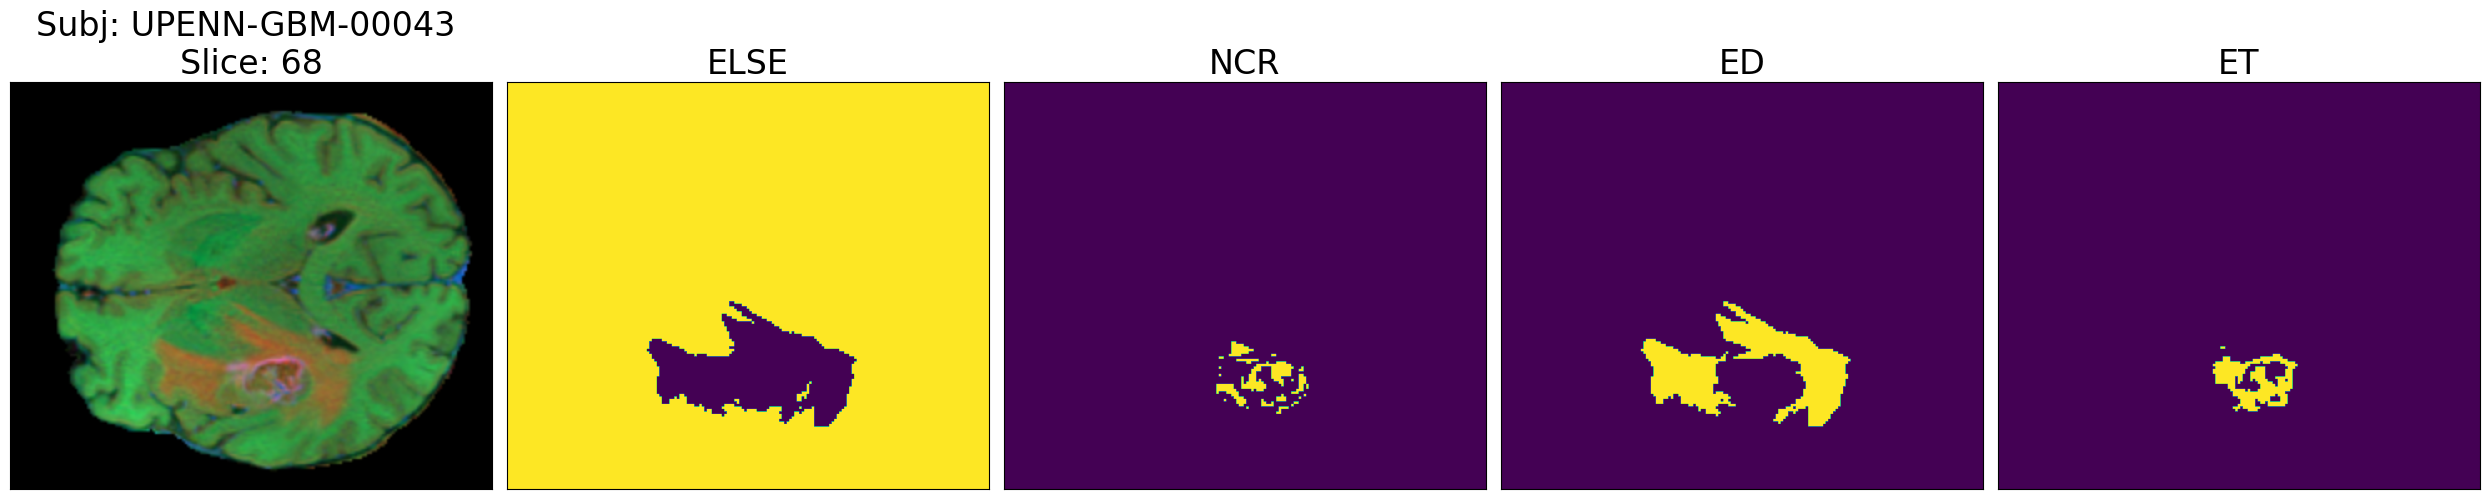

In [34]:
# print info about a dataset for any test index
train_input = mft.peek(train_dataset, 120)

# plot the input and segmentation masks
train_img_title = f"Subj: {train_input['subj_no']} \nSlice: {train_input['file_no']}"
mf_utils.plot_mask_labels(class_labels=train_input["class_labels"].tolist(),
             pixel_values = train_input['pixel_values'].numpy(),
             mask_labels = train_input['mask_labels'],
             title = train_img_title)

pixel_values torch.Size([3, 326, 386])
pixel_mask torch.Size([326, 386])
mask_labels torch.Size([4, 326, 386])
class_labels torch.Size([4])
dataset length 300
class labels tensor([0, 1, 2, 3])


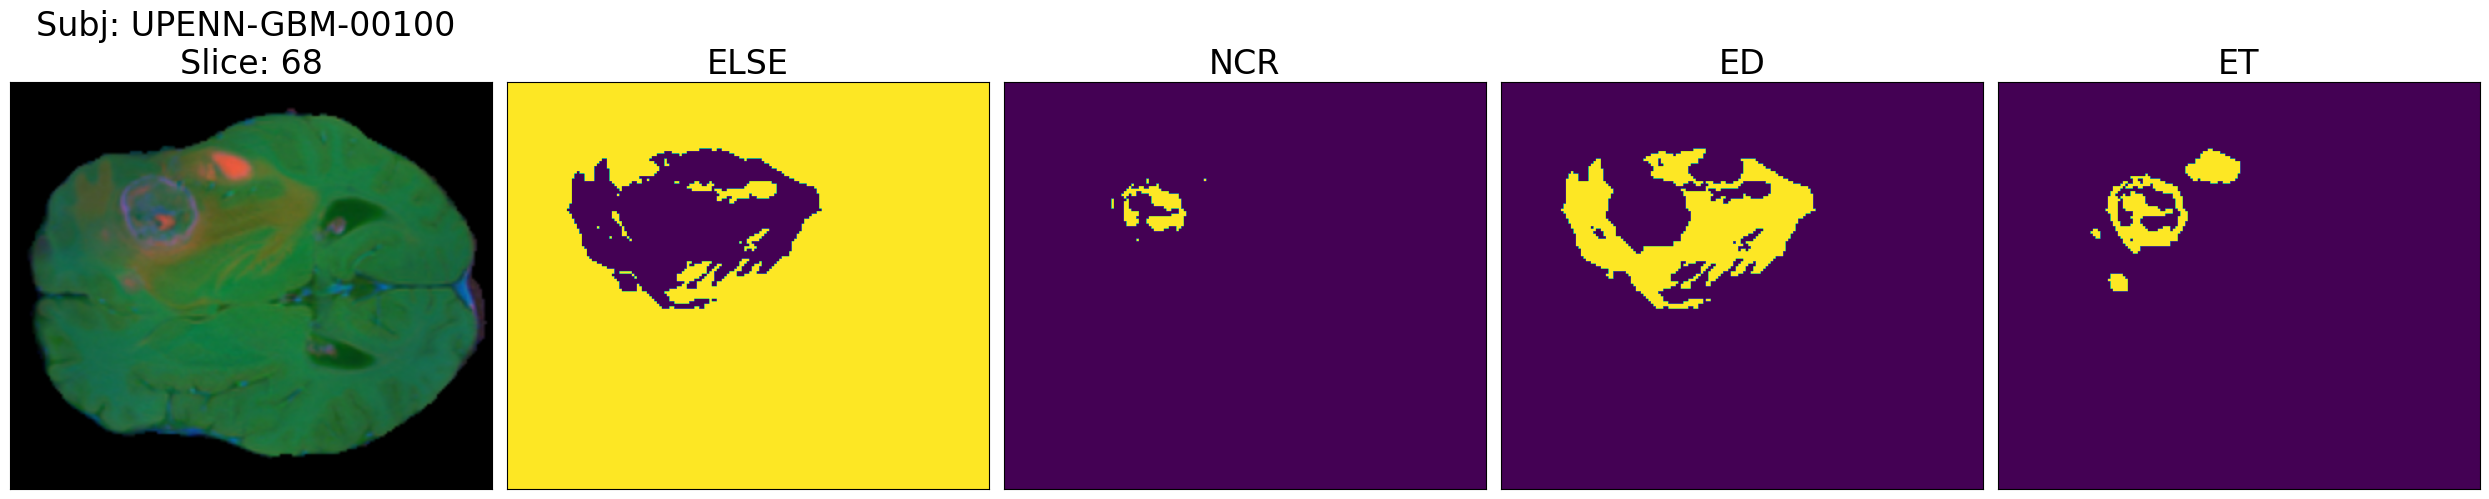

In [35]:
# peek at the val dataset
val_input = mft.peek(val_dataset, 80)

# plot val dataset
val_img_title = f"Subj: {val_input['subj_no']} \nSlice: {val_input['file_no']}"
mf_utils.plot_mask_labels(class_labels=val_input["class_labels"].tolist(),
             pixel_values = val_input['pixel_values'].numpy(),
             mask_labels = val_input['mask_labels'],
             title= val_img_title)

pixel_values torch.Size([3, 326, 386])
pixel_mask torch.Size([326, 386])
mask_labels torch.Size([4, 326, 386])
class_labels torch.Size([4])
dataset length 290
class labels tensor([0, 1, 2, 3])


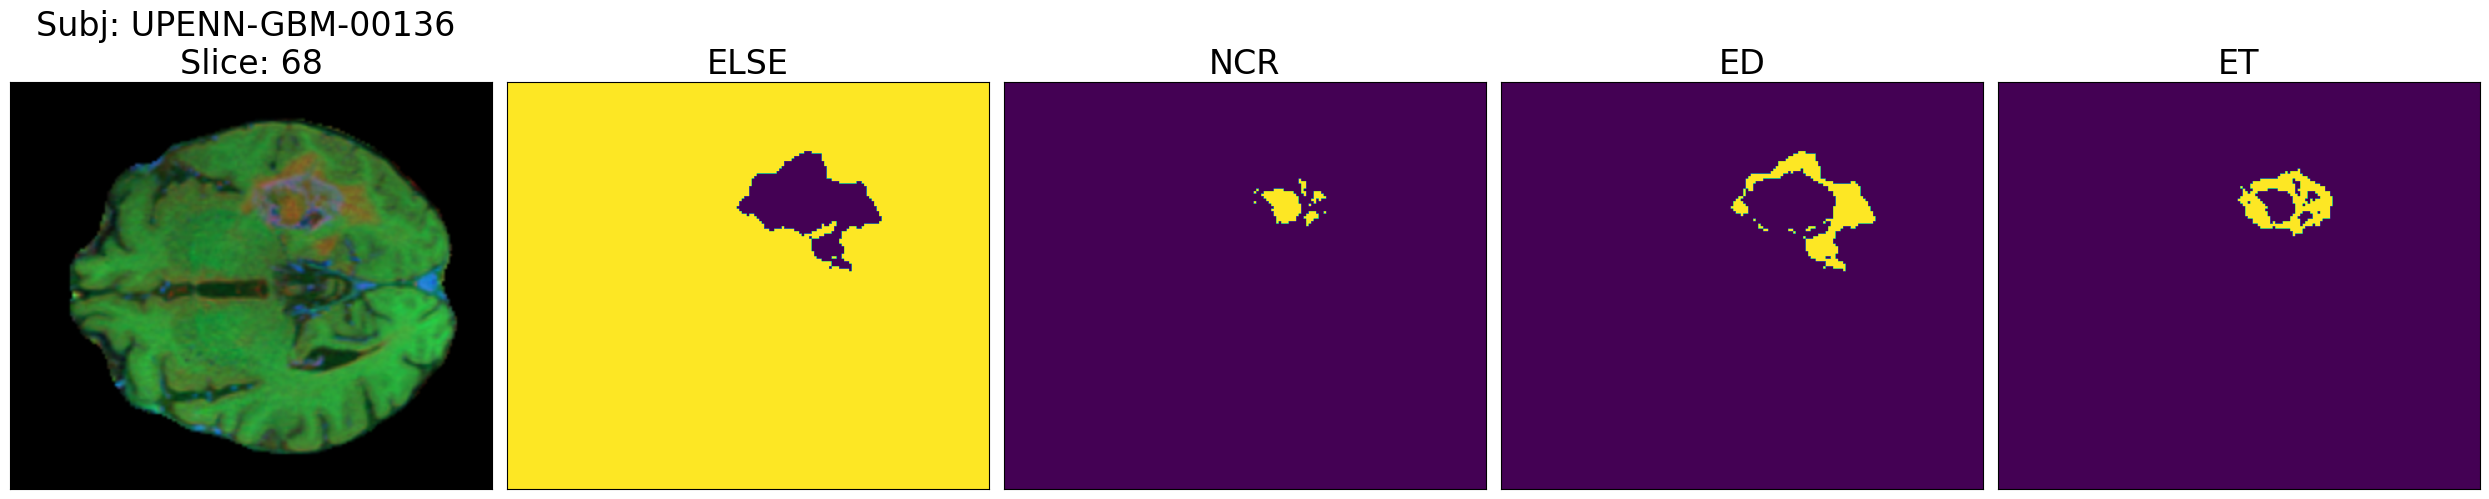

In [36]:
# peek at the test dataset
test_input = mft.peek(test_dataset, 80)

# plot val dataset
test_img_title = f"Subj: {test_input['subj_no']} \nSlice: {test_input['file_no']}"
mf_utils.plot_mask_labels(class_labels=test_input["class_labels"].tolist(),
             pixel_values = test_input['pixel_values'].numpy(),
             mask_labels = test_input['mask_labels'],
             title= test_img_title)

## 3. Fine-tuning Model

### 3.1 Define the model

In [37]:
# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the label dictionary required by the maskformer model
id2label, label2id = mf_utils.get_label_dictionary(mri_common.SEGMENTS)
print(id2label)
print(label2id)

# Load pre-trained maskformer model
# Replace the head of the pre-trained model
# We specify ignore_mismatched_sizes=True to replace the already fine-tuned classification head by a new one
model = MaskFormerForInstanceSegmentation.from_pretrained("zuppif/maskformer-swin-small-ade",
                                                          id2label=id2label,
                                                          label2id=label2id,
                                                          ignore_mismatched_sizes=True)

{0: 'ELSE', 1: 'NCR', 2: 'ED', 3: 'ET'}
{'ELSE': 0, 'NCR': 1, 'ED': 2, 'ET': 3}


Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at zuppif/maskformer-swin-small-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([5]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
# load saved model if needed
if LOAD_MODEL == True:
    model = data_handler.load_torch(file_name=MODEL_FILE_NAME, train_dir_prefix=MODEL_DIR_PREFIX, device=device)

In [39]:
# add outputs
model.config.output_attentions = True
# reset weight of losses
# model.config.mask_weight  = 2.0
# model.config.dice_weight = 0.1

# print model config
configuration = model.config
print(configuration)

MaskFormerConfig {
  "_name_or_path": "zuppif/maskformer-swin-small-ade",
  "architectures": [
    "MaskFormerForInstanceSegmentation"
  ],
  "backbone_config": {
    "depths": [
      2,
      2,
      18,
      2
    ],
    "drop_path_rate": 0.3,
    "embed_dim": 96,
    "hidden_size": 768,
    "image_size": 224,
    "in_channels": 3,
    "model_type": "swin",
    "num_heads": [
      3,
      6,
      12,
      24
    ],
    "out_features": [
      "stage4"
    ],
    "out_indices": [
      4
    ],
    "path_norm": true,
    "pretrain_img_size": 224,
    "window_size": 7
  },
  "ce_weight": 1.0,
  "cross_entropy_weight": 1.0,
  "decoder_config": {
    "max_position_embeddings": 1024,
    "model_type": "detr",
    "scale_embedding": false
  },
  "dice_weight": 1.0,
  "fpn_feature_size": 256,
  "id2label": {
    "0": "ELSE",
    "1": "NCR",
    "2": "ED",
    "3": "ET"
  },
  "init_std": 0.02,
  "init_xavier_std": 1.0,
  "label2id": {
    "ED": 2,
    "ELSE": 0,
    "ET": 3,
    "NCR

In [40]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(BATCH_SIZE, 3, WIDTH, HEIGHT), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                                                         Input Shape          Output Shape         Param #              Trainable
MaskFormerForInstanceSegmentation (MaskFormerForInstanceSegmentation)                           [2, 3, 386, 326]     [2, 8, 100, 100]     --                   True
├─MaskFormerModel (model)                                                                       [2, 3, 386, 326]     [2, 8, 100, 100]     --                   True
│    └─MaskFormerPixelLevelModule (pixel_level_module)                                          [2, 3, 386, 326]     --                   --                   True
│    │    └─MaskFormerSwinBackbone (encoder)                                                    [2, 3, 386, 326]     [2, 96, 97, 82]      48,840,138           True
│    │    └─MaskFormerPixelDecoder (decoder)                                                    [2, 96, 97, 82]      --                   4,304,640            True
│    └─Mask

The warning is telling us that we're throwing away the classification head and randomly initializing a new one.

### 3.2 Calculate initial loss

Let's take the first batch of the training dataset and forward it through the model, see if we get a loss that makes sense.

This is another trick from [this amazing blog post](http://karpathy.github.io/2019/04/25/recipe/) if you wanna debug your neural networks.

In [41]:
# obtain a batch of data
batch = next(iter(train_dataloader))

model.to(device)

outputs = model(
        pixel_values=batch["pixel_values"].to(device),
        mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
        class_labels=[labels.to(device) for labels in batch["class_labels"]],
      )
loss_init = outputs.loss.item()

# print basic info
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

# print some info
print([label.shape for label in batch["class_labels"]])
print([label.shape for label in batch["mask_labels"]])

# print loss
print('Initial Loss is:', loss_init)

pixel_values torch.Size([2, 3, 326, 386])
pixel_mask torch.Size([2, 326, 386])
class_labels 2
mask_labels 2
subj_no 2
file_no 2
[torch.Size([3]), torch.Size([3])]
[torch.Size([3, 326, 386]), torch.Size([3, 326, 386])]
Initial Loss is: 0.3049199879169464


### 3.3 Train the model

In [42]:
mf_train = MaskFormerTrain(model=model, n_epoch=N_EPOCH)
if RETRAIN:
    mf_train.train(train_dataloader=train_dataloader, val_dataloader=val_dataloader, train_id=TRAIN_ID, train_dir_prefix=TRAIN_DIR_PREFIX)

## 4. Evaluation

### 4.1 Make prediction on one sample

#### 4.1.1 Model prediction and visualization on one sample

In [43]:
# define a transform without resizing
org_transform = A.Compose([A.Normalize(mean=mf_utils.ADE_MEAN, std=mf_utils.ADE_STD)])

# create a test data loader without shuffling
QC_TYPE = 'val'
# QC_TYPE = 'test'

# fixed batch size for now
if QC_TYPE == 'train':
    # uses the same transformation during training
    qc_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    # new dataloader without resized image
    org_dataset = MaskformerMRIDataset(data_dir=data_dir_train, data_list=train_data_list, processor=processor, transform=org_transform, augment=False)
    org_dataloader = DataLoader(org_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
elif QC_TYPE == 'val':
    # uses the same transformation during training
    qc_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    # new dataloader without resized image
    org_dataset = MaskformerMRIDataset(data_dir=data_dir_val, data_list=val_data_list, processor=processor, transform=org_transform, augment=False)
    org_dataloader = DataLoader(org_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
else:
    # uses the same transformation during training
    qc_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    # new dataloader without resized image
    org_dataset = MaskformerMRIDataset(data_dir=data_dir_test, data_list=test_data_list, processor=processor, transform=org_transform, augment=False)
    org_dataloader = DataLoader(org_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [44]:
# recall slice range used
file_no_min, file_no_max

(68, 78)

In [45]:
# TO QC a specific subj and a specific file no, search for the index in the datasetlist
target_subj = "UPENN-GBM-00008"
test_file_no = 73

# for this example, we are trying to find the file from the val_data_list
# find the index/indices in val_data_list corresponding to the 2d slices for the specified patient
subj_indices = [index for index, file_name in enumerate(val_data_list) if target_subj in file_name]

assert test_file_no < file_no_max and test_file_no > file_no_min, "test file should be within the specified sample slice"

# if using a smaller sample, start counting from file_no_min
offset = test_file_no - file_no_min

# get relative index of test_file_no
target_file_no = subj_indices[0] + offset
target_batch = int(target_file_no//BATCH_SIZE)
test_idx = target_file_no%BATCH_SIZE
print("target batch", target_batch)
print("test idx", test_idx)

target batch 2
test idx 1


In [46]:
# we can also override target_batch and test_idx if testing randomly
# target_batch = 3
# test_idx = 3

for ibatch, batch in enumerate(qc_dataloader):
    if ibatch == target_batch:
        test_batch = batch
        break
    else:
        continue

for k,v in test_batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)
  else:
    print(k, len(v))

test_image =  test_batch["pixel_values"][test_idx]
test_pixel_mask = test_batch["pixel_mask"][test_idx]
test_mask_labels = test_batch["mask_labels"][test_idx]
test_class_labels = test_batch["class_labels"][test_idx]
test_subj = test_batch["subj_no"][test_idx] + "_" +  test_batch["file_no"][test_idx]
print(test_subj)

pixel_values torch.Size([2, 3, 326, 386])
pixel_mask torch.Size([2, 326, 386])
class_labels 2
mask_labels 2
subj_no 2
file_no 2
UPENN-GBM-00008_73


In [47]:
# prepare transform to for inferencing. the setup should be the same as train_transform
predict_transform = A.Compose([
    A.Resize(width=WIDTH, height=HEIGHT),
    A.Normalize(mean=mf_utils.ADE_MEAN, std=mf_utils.ADE_STD),
])

# instantiate MaskFormerInference class to perform prediction
test_mf_inference=MaskFormerInference(data_dir=data_dir_val,
                                     model=model,
                                     processor=processor,
                                     upscaled_transform=predict_transform,
                                     scale_to_orig_size=False)


# result = this is the method that runs MaskFormer post_process_semantic_segmentation
outputs, batch_results = test_mf_inference.predict_segm(test_batch, batch_size=BATCH_SIZE)

# use test_idx to get results from batch
results = batch_results[test_idx]

for segment_info in results['segments_info']:
    print(segment_info)
print("segmentation result shape", results['segmentation'].shape)
print("segmentation unique values", np.unique( results['segmentation']))

mri directory /content/data/images_annot_reduced_norm_2d/val/depth
{'id': 0, 'label_id': 1, 'was_fused': False, 'score': 0.945819}
{'id': 1, 'label_id': 0, 'was_fused': False, 'score': 0.987644}
{'id': 2, 'label_id': 3, 'was_fused': False, 'score': 0.937905}
{'id': 3, 'label_id': 2, 'was_fused': False, 'score': 0.843661}
segmentation result shape torch.Size([326, 386])
segmentation unique values [-1.  0.  1.  2.  3.]


In [48]:
# Obtain labels in true, predict, intersection and union
labels_true = []
for label in test_class_labels.numpy():
    labels_true.append( id2label[label] )

labels_pred = []
for segment in results['segments_info']:
    labels_pred.append( id2label[segment['label_id']] )

# remove duplicates
labels_pred = list(set(labels_pred))
labels_all = list(set(labels_true) | set(labels_pred))
labels_common = list(set(labels_true) & set(labels_pred))

# QC all true and predicted categories
print("True labels:",labels_true)
print("Predicted labels:",labels_pred)
print("All labels:", labels_all)
print("Common labels:",labels_common)

True labels: ['ELSE', 'NCR', 'ED', 'ET']
Predicted labels: ['ED', 'NCR', 'ET', 'ELSE']
All labels: ['NCR', 'ET', 'ELSE', 'ED']
Common labels: ['ED', 'NCR', 'ET', 'ELSE']


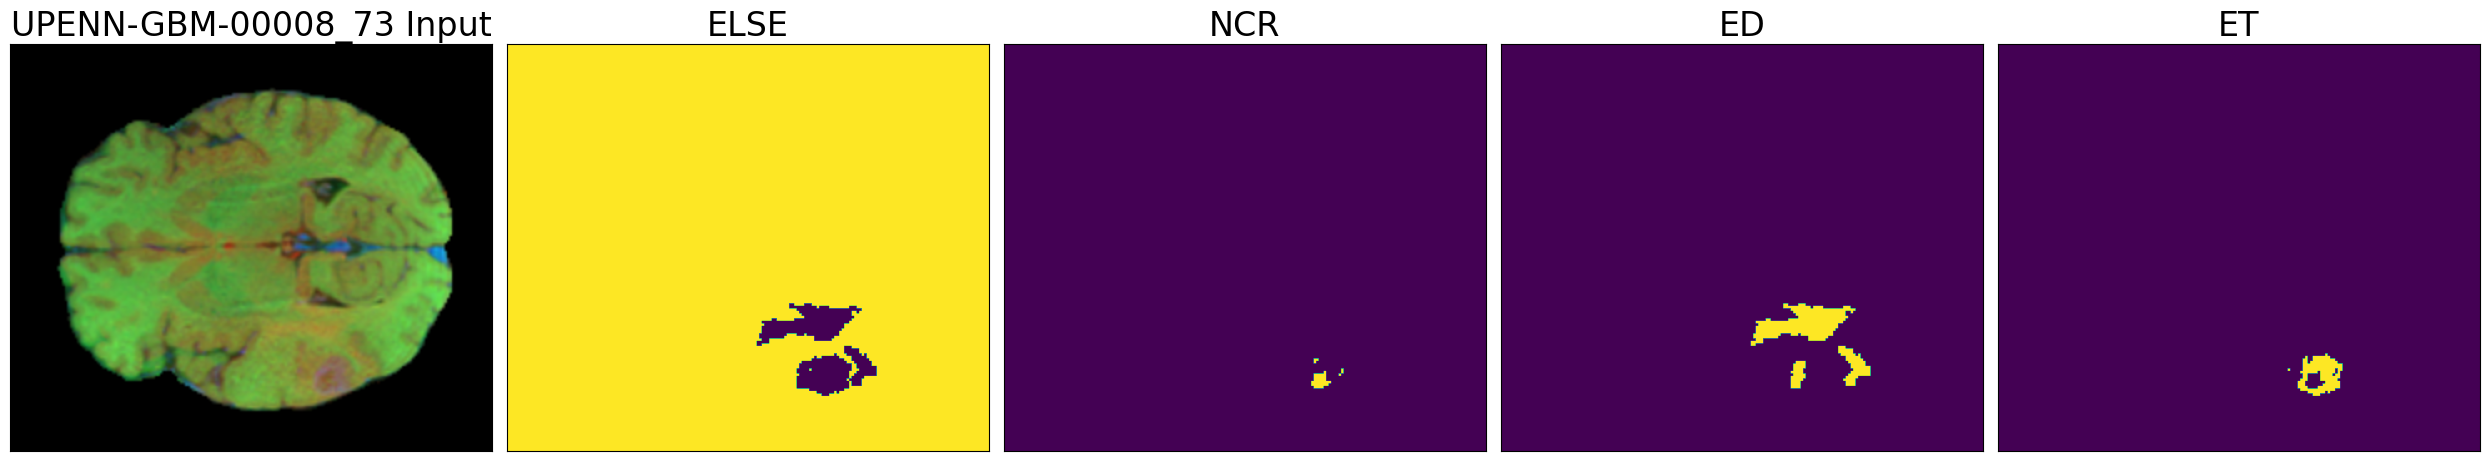

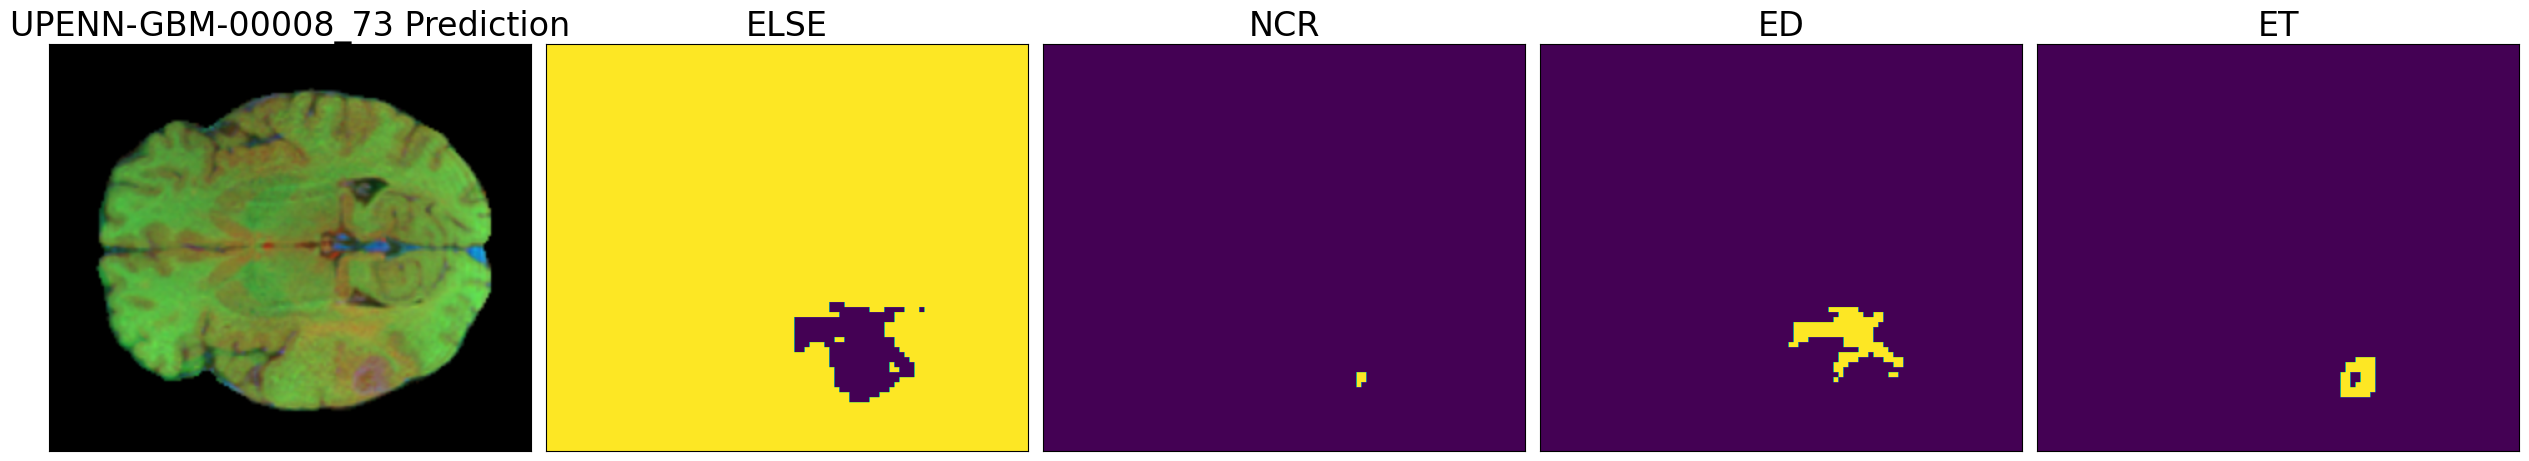

In [49]:
# QC predicted masks with segmentation with Maskformer resolution

# this will convert post_process_semantic_segmentation to masks so the format is similar with the maskformer input
pred_mask_labels, pred_class_labels = get_mask_from_segm_result(segm_result=results)
input_class_labels = test_class_labels.numpy()

# the conversion will allow us to compare the two side by side
mf_utils.plot_mask_labels(class_labels= input_class_labels,
             pixel_values = test_image.numpy(),
             mask_labels = test_mask_labels,
             title= test_subj + " Input")

# plot predicted mask labels
mf_utils.plot_mask_labels(class_labels=pred_class_labels,
             pixel_values = test_image.numpy(),
             mask_labels = pred_mask_labels,
             title= test_subj + " Prediction")


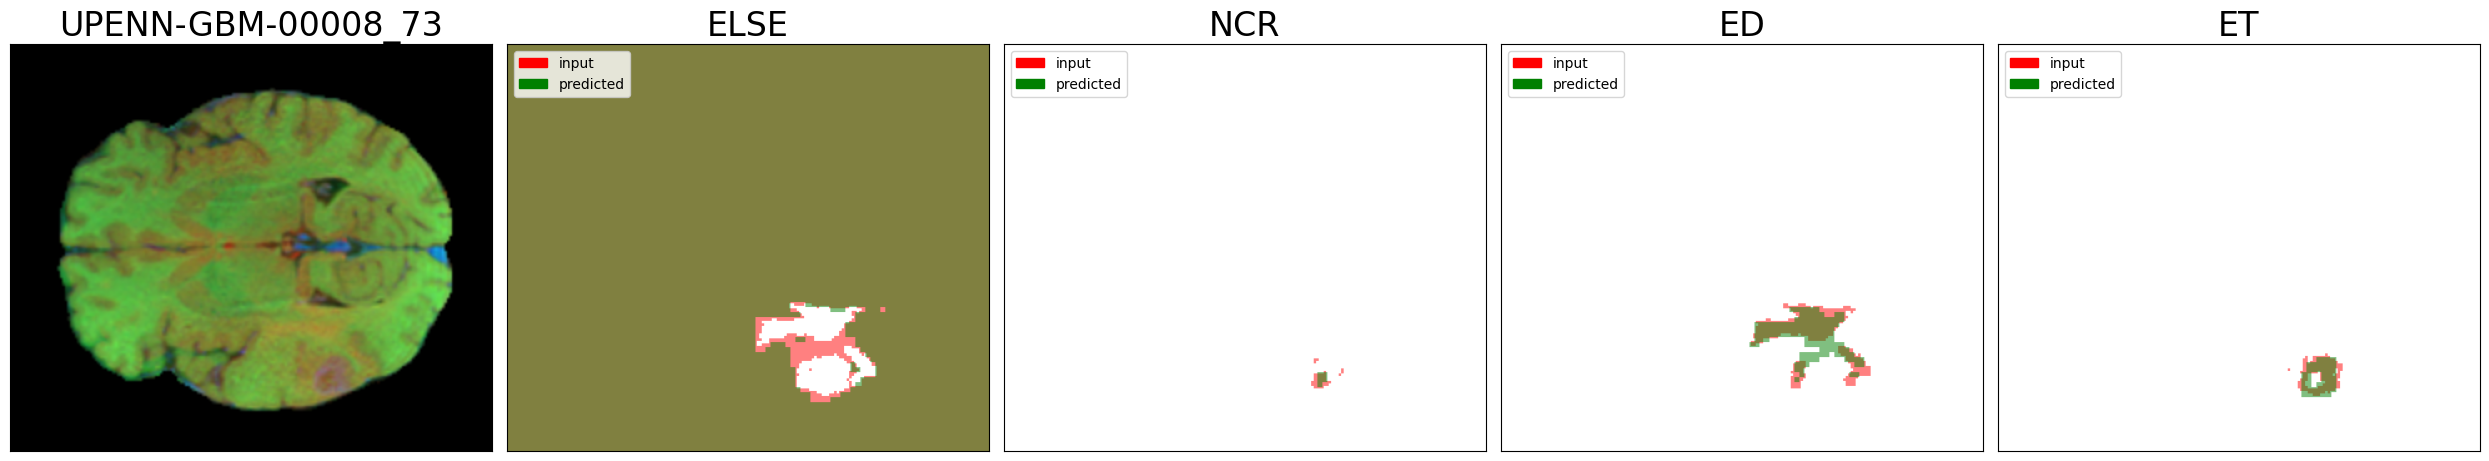

In [50]:
# plot predicted segment over of input segment.
# note: if a segment is predicted but does not exist in the input mask, it will not show here
mf_utils.plot_mask_comparison(input_class_labels=input_class_labels,
                     pred_class_labels=pred_class_labels,
                     input_pixel_values=test_image.numpy(),
                     input_mask_labels=test_mask_labels,
                     pred_mask_labels=pred_mask_labels,
                     title=test_subj)


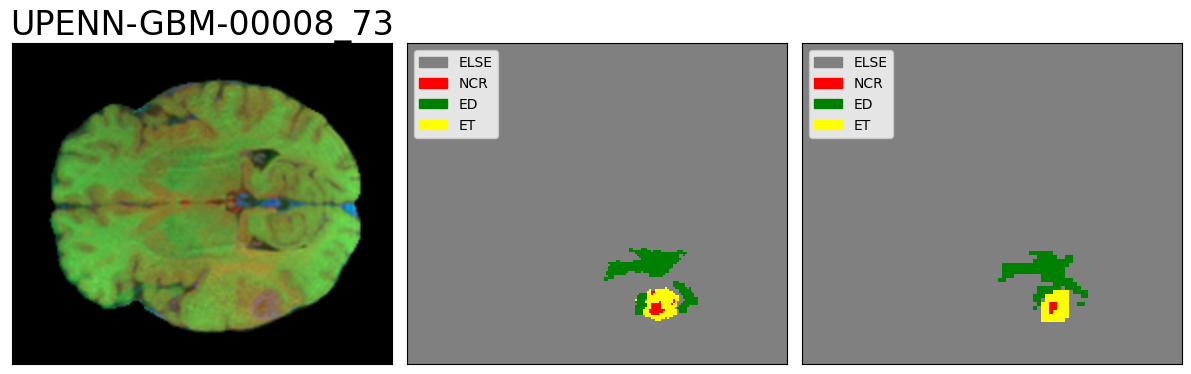

In [51]:
# mask_to_segmentation will flatten mask labels with shape  (n_label, width, height) to a segmentation image (width, height)
input_segmentation = mf_utils.mask_to_segmentation(mask_labels=test_mask_labels, class_labels=input_class_labels)
pred_segmentation = mf_utils.mask_to_segmentation(mask_labels=pred_mask_labels, class_labels=pred_class_labels)

mf_utils.plot_segmentation_comparison(
        input_pixel_values=test_image.numpy(),
        input_segmentation=input_segmentation,
        pred_segmentation=pred_segmentation,
        title=test_subj,
        loc="upper left")

#### 4.1.2 Calculate metrics on predicted sample (1 slice only)

In [52]:
# review dimensions and predicitios
all_labels = list(id2label.keys())
print("all segments:", all_labels)

print("\nlabels:")
input_class_labels = list(test_class_labels.numpy())
print("input_class_labels", input_class_labels)
print("pred_class_labels", pred_class_labels)

print("\nsegmentation shapes:")
print("true_mask shape", test_mask_labels.shape)
print("pred_mask shape", pred_mask_labels.shape)
print("note that dimension changes based on the number of labels")


all segments: [0, 1, 2, 3]

labels:
input_class_labels [0, 1, 2, 3]
pred_class_labels [0, 1, 2, 3]

segmentation shapes:
true_mask shape torch.Size([4, 326, 386])
pred_mask shape (4, 326, 386)
note that dimension changes based on the number of labels


In [53]:
calc_slice_metrics(all_labels, id2label, test_mask_labels, pred_mask_labels, input_class_labels, pred_class_labels)

Metrics for 0 - ELSE:
Dice Score 0.9929775740710427
HD95 5.0
Specificity 0.9556010928961749
Sensitivity 0.9870960393139584
Precision 0.9989296182854132
Recall 0.9870960393139584

Metrics for 1 - NCR:
Dice Score 0.5573770491803278
HD95 12.122149391964987
Specificity 0.999904513336304
Sensitivity 0.4146341463414634
Precision 0.85
Recall 0.4146341463414634

Metrics for 2 - ED:
Dice Score 0.717948717948718
HD95 7.0710678118654755
Specificity 0.9954764289637791
Sensitivity 0.7137254901960784
Precision 0.7222222222222222
Recall 0.7137254901960784

Metrics for 3 - ET:
Dice Score 0.7548476454293629
HD95 4.0
Specificity 0.9986012532770637
Sensitivity 0.7527624309392266
Precision 0.7569444444444444
Recall 0.7527624309392266



#### 4.1.3 QC Resized Transform

In [54]:
# obtain one batch of original data.
# here we use org_dataloader which was initialized in section 4.1.1
# recall that this is the dataloader which does not resize the image
for ibatch, batch in enumerate(org_dataloader):
    if ibatch == target_batch:
        org_batch = batch
        break
    else:
        continue

org_image =  org_batch["pixel_values"][test_idx]
org_mask_labels = org_batch["mask_labels"][test_idx]
org_class_labels = org_batch["class_labels"][test_idx]
org_subj = org_batch["subj_no"][test_idx] + "_" +  org_batch["file_no"][test_idx]
print(org_subj)

UPENN-GBM-00008_73


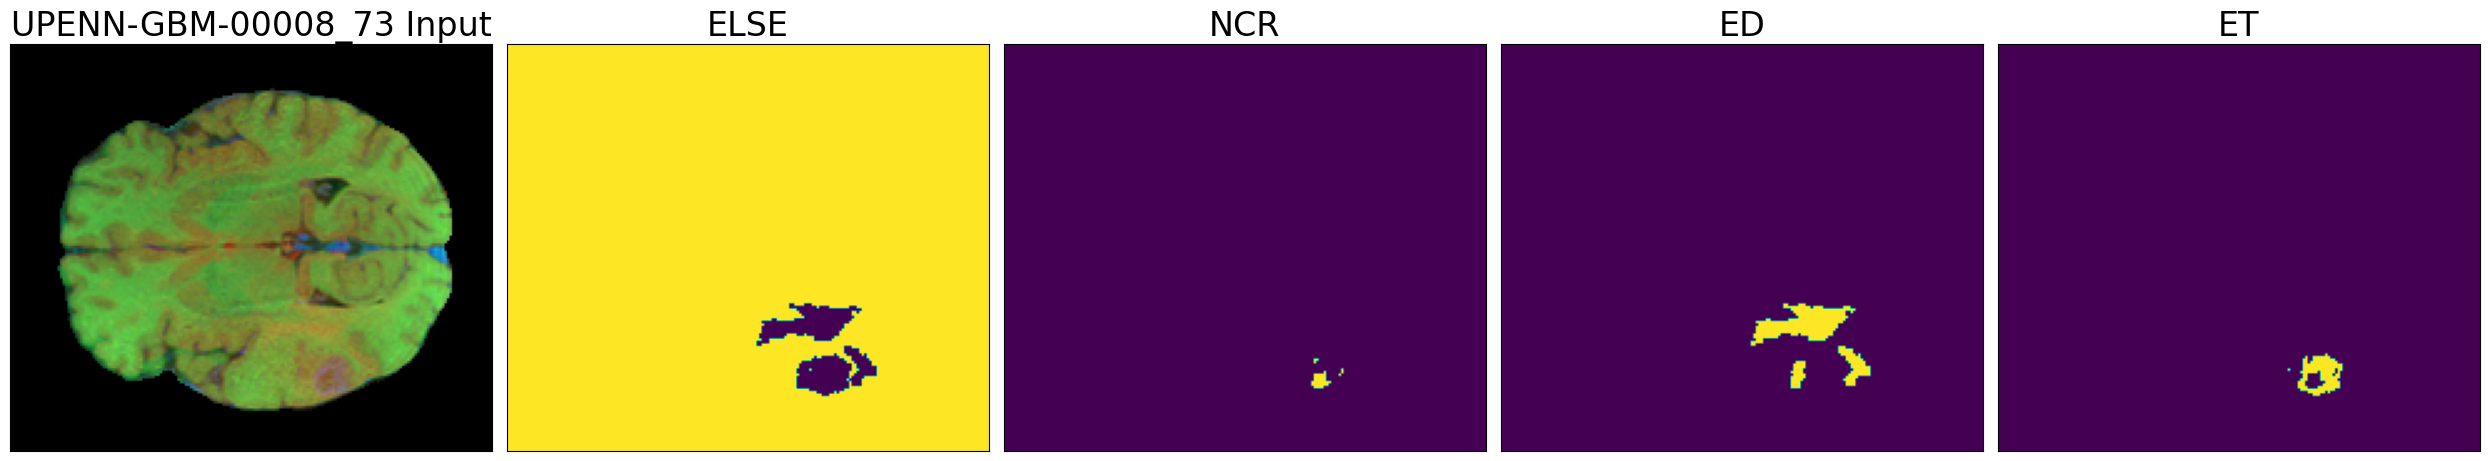

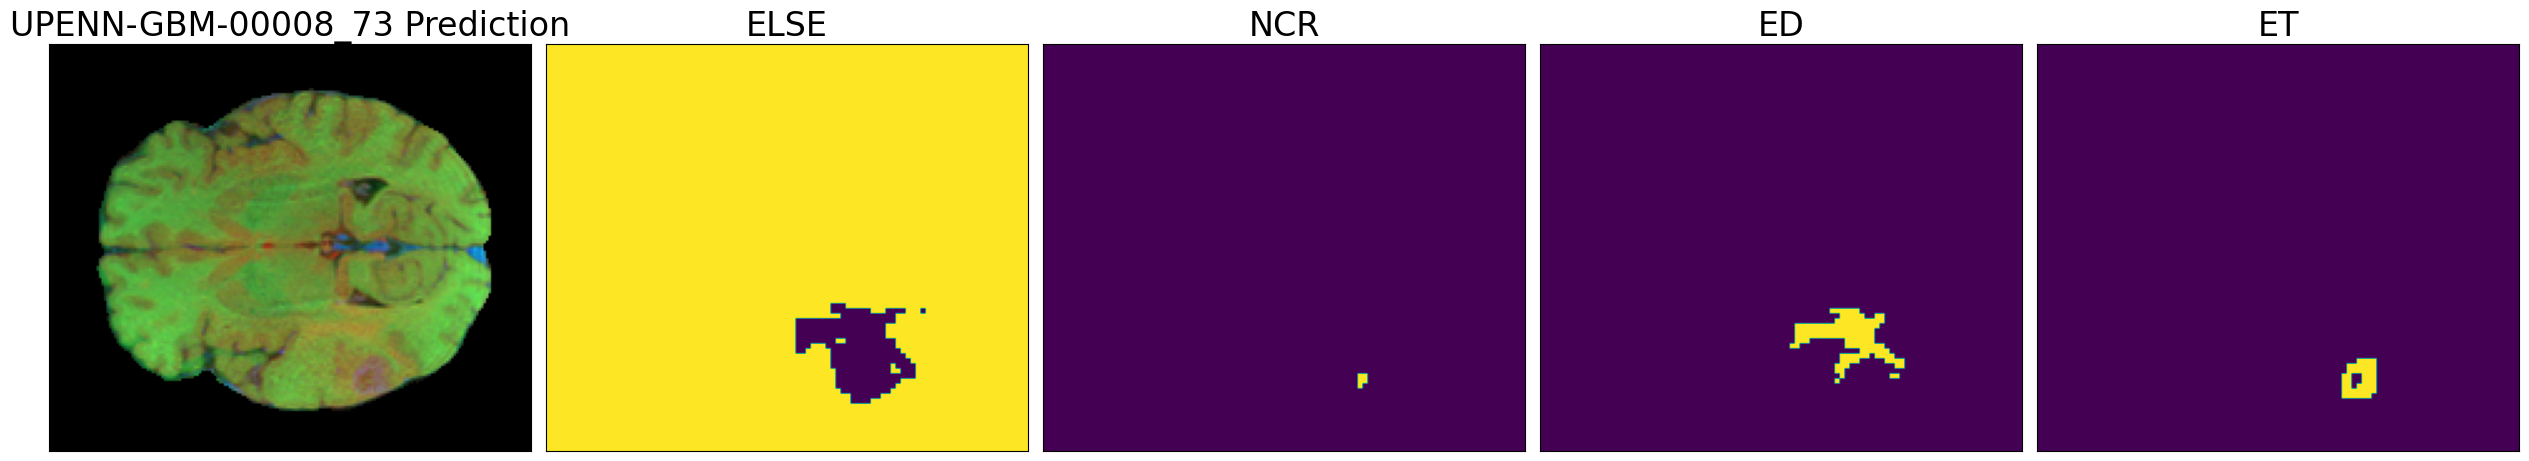

In [55]:
# resize predicted mask from 4.1.1 to original size
pred_mask_labels_rs = mf_utils.resize_mask(pred_mask_labels, orig_dim)

# plot input mask labels
org_input_class_labels = org_class_labels.numpy()
mf_utils.plot_mask_labels(class_labels= org_input_class_labels,
             pixel_values = org_image.numpy(),
             mask_labels = org_mask_labels,
             title= test_subj + " Input")

# plot predicted mask labels
mf_utils.plot_mask_labels(class_labels=pred_class_labels,
             pixel_values = org_image.numpy(),
             mask_labels = pred_mask_labels_rs,
             title= test_subj + " Prediction")



orig segmentation shape (163, 193)
pred segmentation shape (163, 193)



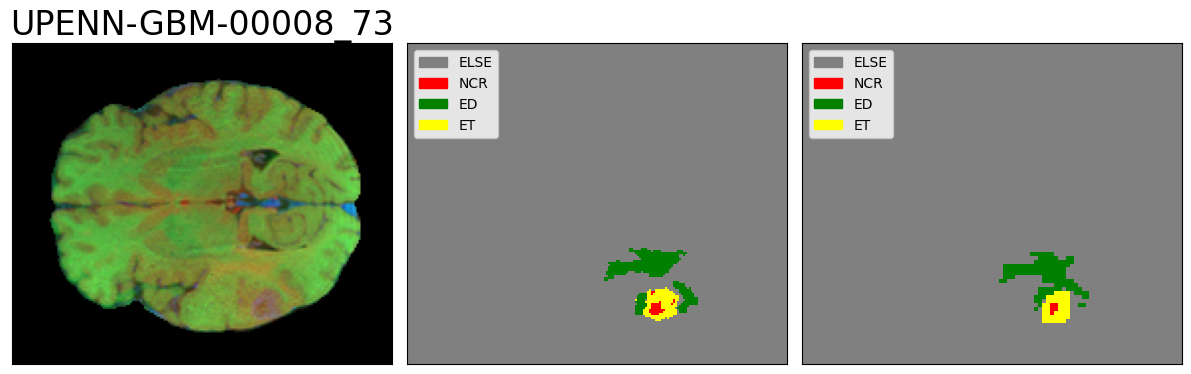

In [56]:
org_segmentation = mf_utils.mask_to_segmentation(mask_labels=org_mask_labels, class_labels=org_input_class_labels)
pred_segmentation = mf_utils.mask_to_segmentation(mask_labels=pred_mask_labels_rs, class_labels=pred_class_labels)

print("orig segmentation shape", org_segmentation.shape)
print("pred segmentation shape", pred_segmentation.shape)
print("")

# plot the 2 segmentations
mf_utils.plot_segmentation_comparison(
        input_pixel_values=org_image.numpy(),
        input_segmentation=org_segmentation,
        pred_segmentation=pred_segmentation,
        title=test_subj,
        loc="upper left")

orig segmentation shape (163, 193)
pred segmentation shape (163, 193)



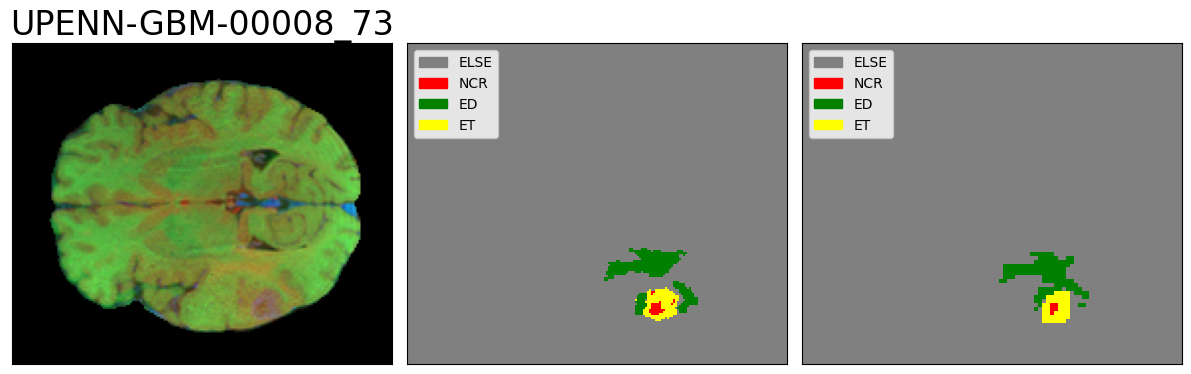

In [57]:
# compare to actual file instead of using the maskformer input mask
org_segmentation_mri = data_handler.load_mri(target_subj, local_path=data_dir_val, file_no=test_file_no)

print("orig segmentation shape", org_segmentation_mri.shape)
print("pred segmentation shape", pred_segmentation.shape)
print("")

# plot the 2 segmentations
mf_utils.plot_segmentation_comparison(
        input_pixel_values=org_image.numpy(),
        input_segmentation=org_segmentation_mri,
        pred_segmentation=pred_segmentation,
        title=test_subj,
        loc="upper left")


#### 4.1.4 Calculate metrics on resized sample

In [58]:
# review dimensions and predictions
print("\nlabels:")
org_input_class_labels = list(org_class_labels.numpy())
print("org_class_labels", org_input_class_labels)
print("pred_class_labels", pred_class_labels)

print("\nsegmentation shapes:")
print("true_mask shape (orig size)", org_mask_labels.shape)
print("pred_mask shape (resized to orig)", pred_mask_labels_rs.shape)
print("note that dimension changes based on the number of labels")


labels:
org_class_labels [0, 1, 2, 3]
pred_class_labels [0, 1, 2, 3]

segmentation shapes:
true_mask shape (orig size) torch.Size([4, 163, 193])
pred_mask shape (resized to orig) (4, 163, 193)
note that dimension changes based on the number of labels


In [59]:
# recalculate metrics using resized prediction
calc_slice_metrics(all_labels, id2label, org_mask_labels, pred_mask_labels_rs, org_input_class_labels, pred_class_labels)

Metrics for 0 - ELSE:
Dice Score 0.9929939433622524
HD95 2.8284271247461903
Specificity 0.9562841530054644
Sensitivity 0.9871123116477365
Precision 0.9989460856964069
Recall 0.9871123116477365

Metrics for 1 - NCR:
Dice Score 0.5573770491803278
HD95 6.082762530298219
Specificity 0.999904513336304
Sensitivity 0.4146341463414634
Precision 0.85
Recall 0.4146341463414634

Metrics for 2 - ED:
Dice Score 0.6942800788954635
HD95 3.605551275463989
Specificity 0.9950886943035316
Sensitivity 0.6901960784313725
Precision 0.6984126984126984
Recall 0.6901960784313725

Metrics for 3 - ET:
Dice Score 0.7202216066481995
HD95 2.23606797749979
Specificity 0.9984014323166442
Sensitivity 0.7182320441988951
Precision 0.7222222222222222
Recall 0.7182320441988951



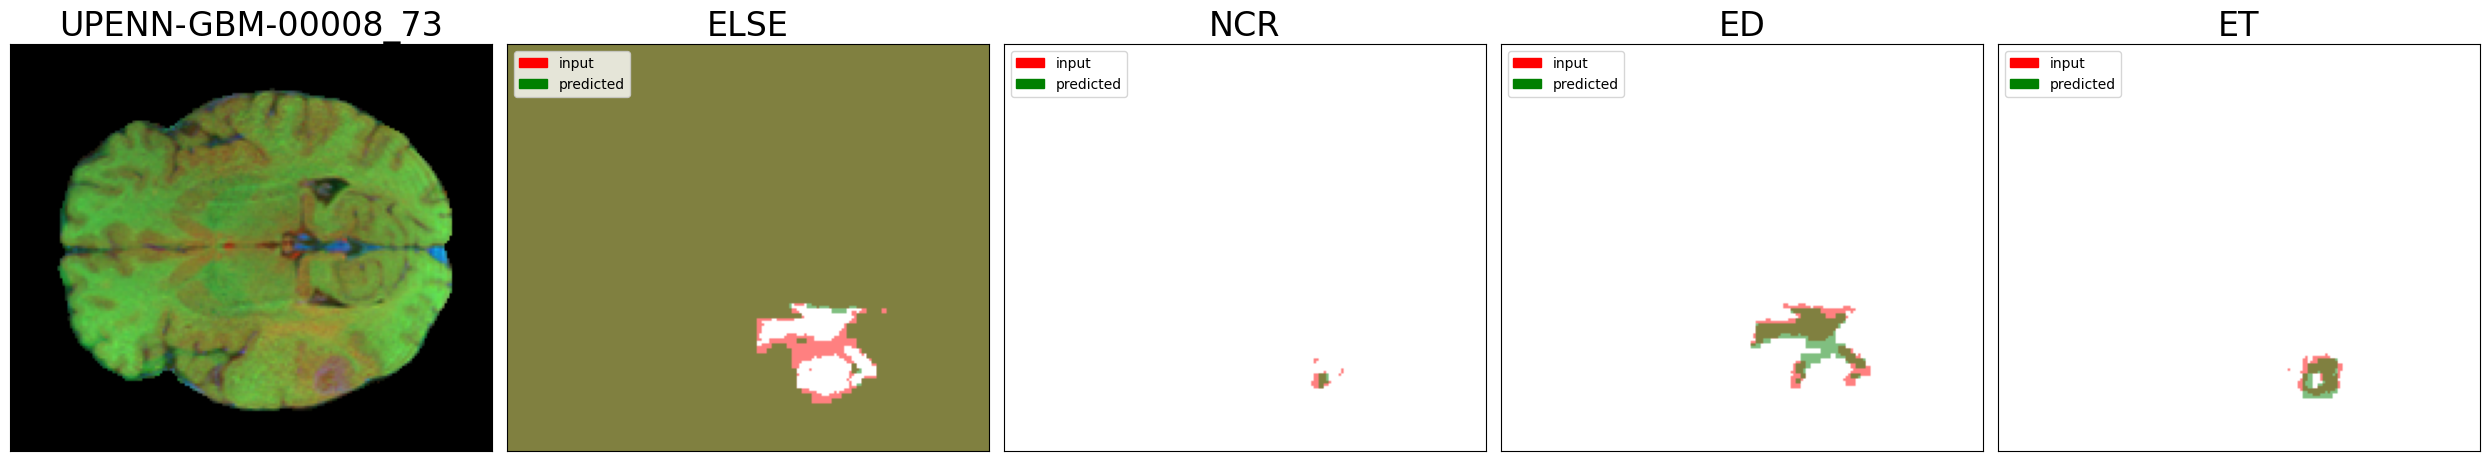

In [60]:
# plot mask overlayed against each other
mf_utils.plot_mask_comparison(input_class_labels=org_input_class_labels,
                     pred_class_labels=pred_class_labels,
                     input_pixel_values=org_image.numpy(),
                     input_mask_labels=org_mask_labels,
                     pred_mask_labels=pred_mask_labels_rs,
                     title=test_subj)

### 4.2 Make predictions on all data and compute metrics

#### 4.2.1 Predict for 1 patient (3d volume) - not resized

In [61]:
# define a transform for upscaled predictions. note that this has the same transformation we did during training.
predict_transform = A.Compose([
    A.Resize(width=WIDTH, height=HEIGHT),
    A.Normalize(mean=mf_utils.ADE_MEAN, std=mf_utils.ADE_STD),
])

mf_val_inference=MaskFormerInference(data_dir=data_dir_val,
                                     model=model,
                                     processor=processor,
                                     upscaled_transform=predict_transform,
                                     scale_to_orig_size=False)
print("total validation files", len(mf_val_inference.all_files))

mri directory /content/data/images_annot_reduced_norm_2d/val/depth
total validation files 4380


In [62]:
# record start time
start_time = time.time()
pred_target_subj = "UPENN-GBM-00131"
image_3d, mask_true_3d, mask_pred_3d, true_class_labels, pred_class_labels = mf_val_inference.predict_patient_mask(subj_id=pred_target_subj)
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: {:.6f} seconds".format(elapsed_time))

# convert from 255 to 0-1
mask_pred_3d_binary = mf_utils.descale_mask(mask_pred_3d)
mask_true_3d_binary = mf_utils.descale_mask(mask_true_3d)

Performing inference on UPENN-GBM-00131
Number of 2d slices for patient 146
Elapsed time: 11.696308 seconds


In [63]:
# instantiate evaluation function to calculate metrics
start_time = time.time()
print("mask_pred_3d_binary shape", mask_pred_3d_binary.shape)
print("mask_true_3d_binary shape", mask_true_3d_binary.shape)

# hausdorff takes 32 seconds
label_names = list(mri_common.SEGMENTS.values())

dice_score, hausdorff, common_metrics_dict = calc_subject_metrics(
                        label_names=label_names,
                        subj_id=pred_target_subj,
                        mask_pred_binary=mask_pred_3d_binary,
                        mask_true_binary=mask_true_3d_binary)

end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: {:.6f} seconds".format(elapsed_time))


print("dice_score", dice_score)
print("hausdorff_val", hausdorff)
print("sensitivity", common_metrics_dict['sensitivity'])
print("specificity", common_metrics_dict['specificity'])

mask_pred_3d_binary shape (4, 146, 326, 386)
mask_true_3d_binary shape (4, 146, 326, 386)
Calculating metrics for  UPENN-GBM-00131
Elapsed time: 9.318666 seconds
dice_score [0.9985405404393617, 0.8617021276595744, 0.8429758216184767, 0.7472505418640122]
hausdorff_val [1.0, 3.4641016151377544, 5.0, 2.23606797749979]
sensitivity [0.9976014990301053, 0.861984282907662, 0.8457565226834632, 0.7433716658680722]
specificity [0.9506449921342423, 0.9998615540425239, 0.9986997333951395, 0.9996638689722337]


#### 4.2.2 Predict for 1 patient (3d volume) - use original size

In [64]:
# define a transform that downscales predicted masks to original dimension masks
org_transform = A.Compose([
    A.Normalize(mean=mf_utils.ADE_MEAN, std=mf_utils.ADE_STD),
])

mf_val_inference_upscaled=MaskFormerInference(data_dir=data_dir_val,
                                              model=model,
                                              processor=processor,
                                              upscaled_transform=predict_transform,
                                              orig_transform=org_transform,
                                              scale_to_orig_size=True,
                                              orig_dim=orig_dim)

print("total validation files", len(mf_val_inference_upscaled.all_files))

mri directory /content/data/images_annot_reduced_norm_2d/val/depth
total validation files 4380


In [65]:
# note: scale_to_orig_size is True by default. Im just making it explicit here
image_3d, mask_true_3d, mask_pred_3d, true_class_labels, pred_class_labels = mf_val_inference_upscaled.predict_patient_mask(subj_id=pred_target_subj)

# convert from 255 to 0-1
mask_pred_3d_binary = mf_utils.descale_mask(mask_pred_3d)
mask_true_3d_binary = mf_utils.descale_mask(mask_true_3d)

# instantiate evaluation function to calculate metrics
orig_dice_score, orig_hausdorff, orig_common_metrics = calc_subject_metrics(
                        label_names=label_names,
                        subj_id=pred_target_subj,
                        mask_pred_binary=mask_pred_3d_binary,
                        mask_true_binary=mask_true_3d_binary)



Performing inference on UPENN-GBM-00131
Number of 2d slices for patient 146
Calculating metrics for  UPENN-GBM-00131


#### 4.2.3 Put the metrics side by side

In [66]:
print("upscaled dice_score", dice_score)
print("orig dice_score", orig_dice_score)
print("")
print("upscaled hausdorff", hausdorff)
print("orig hausdorff", orig_hausdorff)
print("")
print("upscaled sensitivity", common_metrics_dict['sensitivity'])
print("orig sensitivity", orig_common_metrics['sensitivity'])
print("")
print("upscaled ", common_metrics_dict['specificity'])
print("orig specificity", orig_common_metrics['specificity'])


upscaled dice_score [0.9985405404393617, 0.8617021276595744, 0.8429758216184767, 0.7472505418640122]
orig dice_score [0.9984940244913437, 0.8615384615384616, 0.843388112218073, 0.7469705481101035]

upscaled hausdorff [1.0, 3.4641016151377544, 5.0, 2.23606797749979]
orig hausdorff [0.0, 2.23606797749979, 3.1622776601683795, 1.4142135623730951]

upscaled sensitivity [0.9976014990301053, 0.861984282907662, 0.8457565226834632, 0.7433716658680722]
orig sensitivity [0.9975211969888275, 0.8618205631958088, 0.8492384546466484, 0.7433317361443859]

upscaled  [0.9506449921342423, 0.9998615540425239, 0.9986997333951395, 0.9996638689722337]
orig specificity [0.9494493969585737, 0.9998613905880286, 0.9986690607769972, 0.9996629423908373]


#### 4.2.4  Obtain Validation datalist

In [67]:
# Obtain all validation subjects
val_subjs = mf_utils.get_all_subj_ids(data_dir=data_dir_val)
print("total validation data", len(val_subjs))
print("first 5 validation subjects")
val_subjs[:5]

total validation data 30
first 5 validation subjects


['UPENN-GBM-00008',
 'UPENN-GBM-00013',
 'UPENN-GBM-00020',
 'UPENN-GBM-00030',
 'UPENN-GBM-00033']

In [68]:
# this class is used for doing predictions and evaluation on the entire dataset
mf_eval=MaskFormerEvaluation()

#### 4.2.5 Calculate Metrics for Validation Data

In [69]:
# calculate metrics for validation data using mf_val_inference
# note this is calculating scores for the upscaled/resized dataset
print("val metrics_file_name: ", VAL_METRICS_FILENAME)
val_metrics_dict, val_error_files, val_success_files = mf_eval.predict_and_eval(subj_names=val_subjs,
                                                                                mf_inference=mf_val_inference,
                                                                                metrics_dir_prefix=METRICS_DIR_PREFIX,
                                                                                metrics_file_name=VAL_METRICS_FILENAME,
                                                                                recalculate=RECALCULATE_VAL_METRICS)

val metrics_file_name:  metrics_val_sample_training test.joblib
Files with error: []
Total Files evaluated: 30


In [70]:
# UPDATED EVALUATION, downscales predicted masks to original dimension masks
print("val metrics_file_name: ", "upscaled_"+VAL_METRICS_FILENAME)
val_metrics_dict_upscaled, val_error_files_upscaled, val_success_files_upscaled = mf_eval.predict_and_eval(subj_names=val_subjs,
                                                                                mf_inference=mf_val_inference_upscaled,
                                                                                metrics_dir_prefix=METRICS_DIR_PREFIX,
                                                                                metrics_file_name="upscaled_"+VAL_METRICS_FILENAME,
                                                                                recalculate=RECALCULATE_VAL_METRICS)

val metrics_file_name:  upscaled_metrics_val_sample_training test.joblib
Files with error: []
Total Files evaluated: 30


#### 4.2.6 Evaluate Validation Data

##### Summary statistics

In [71]:
# original evaluation using resized dataset
mf_eval.display_statistics(val_metrics_dict)

Summary: precision
            ELSE        NCR         ED         ET
count  30.000000  30.000000  30.000000  30.000000
mean    0.999005   0.732105   0.776005   0.759474
std     0.000812   0.180916   0.155484   0.146074
min     0.996602   0.250000   0.243563   0.161232
25%     0.998735   0.679437   0.742266   0.752089
50%     0.999212   0.756329   0.823211   0.782459
75%     0.999536   0.860013   0.864272   0.826660
max     0.999890   0.946273   0.940587   0.940503


Summary: recall
            ELSE        NCR         ED         ET
count  30.000000  30.000000  30.000000  30.000000
mean    0.996213   0.665906   0.776543   0.780854
std     0.002978   0.191891   0.139947   0.125973
min     0.986694   0.006593   0.353509   0.374895
25%     0.995294   0.563821   0.698527   0.746635
50%     0.996985   0.710093   0.825410   0.786839
75%     0.998253   0.804268   0.861118   0.846234
max     0.999375   0.916696   0.933297   0.962874


Summary: sensitivity
            ELSE        NCR         ED  

In [72]:
# updated evaluation, by transforming predicted masks to original dimension masks
mf_eval.display_statistics(val_metrics_dict_upscaled)

Summary: precision
            ELSE        NCR         ED         ET
count  30.000000  30.000000  30.000000  30.000000
mean    0.999019   0.728706   0.772125   0.754363
std     0.000805   0.180994   0.155586   0.142118
min     0.996671   0.250000   0.240895   0.170139
25%     0.998707   0.668181   0.743747   0.735168
50%     0.999238   0.747341   0.819079   0.778317
75%     0.999572   0.856797   0.861538   0.828201
max     0.999879   0.952837   0.934687   0.930253


Summary: recall
            ELSE        NCR         ED         ET
count  30.000000  30.000000  30.000000  30.000000
mean    0.996086   0.667578   0.777941   0.782121
std     0.003066   0.192692   0.142175   0.122924
min     0.986211   0.006593   0.353460   0.368463
25%     0.994997   0.557801   0.701942   0.749475
50%     0.996988   0.709619   0.828530   0.784256
75%     0.998128   0.809353   0.866158   0.845150
max     0.999317   0.920840   0.931693   0.962827


Summary: sensitivity
            ELSE        NCR         ED  

Final report metric summary

In [73]:
val_mean_scores = mf_eval.get_mean_scores(val_metrics_dict)
val_mean_scores

ELSE       NCR         ED        ET
dice_score   0.997605  0.683791   0.766485  0.761021
hd95         1.426830  7.566148  22.257786  8.503204
sensitivity  0.996213  0.665906   0.776543  0.780854
specificity  0.910894  0.999631   0.997912  0.999325

In [74]:
val_mean_scores_upscaled = mf_eval.get_mean_scores(val_metrics_dict_upscaled)
val_mean_scores_upscaled

ELSE       NCR         ED        ET
dice_score   0.997548  0.683087   0.765287  0.758758
hd95         0.789002  5.103130  13.181871  4.720034
sensitivity  0.996086  0.667578   0.777941  0.782121
specificity  0.911250  0.999623   0.997854  0.999306

Box plots

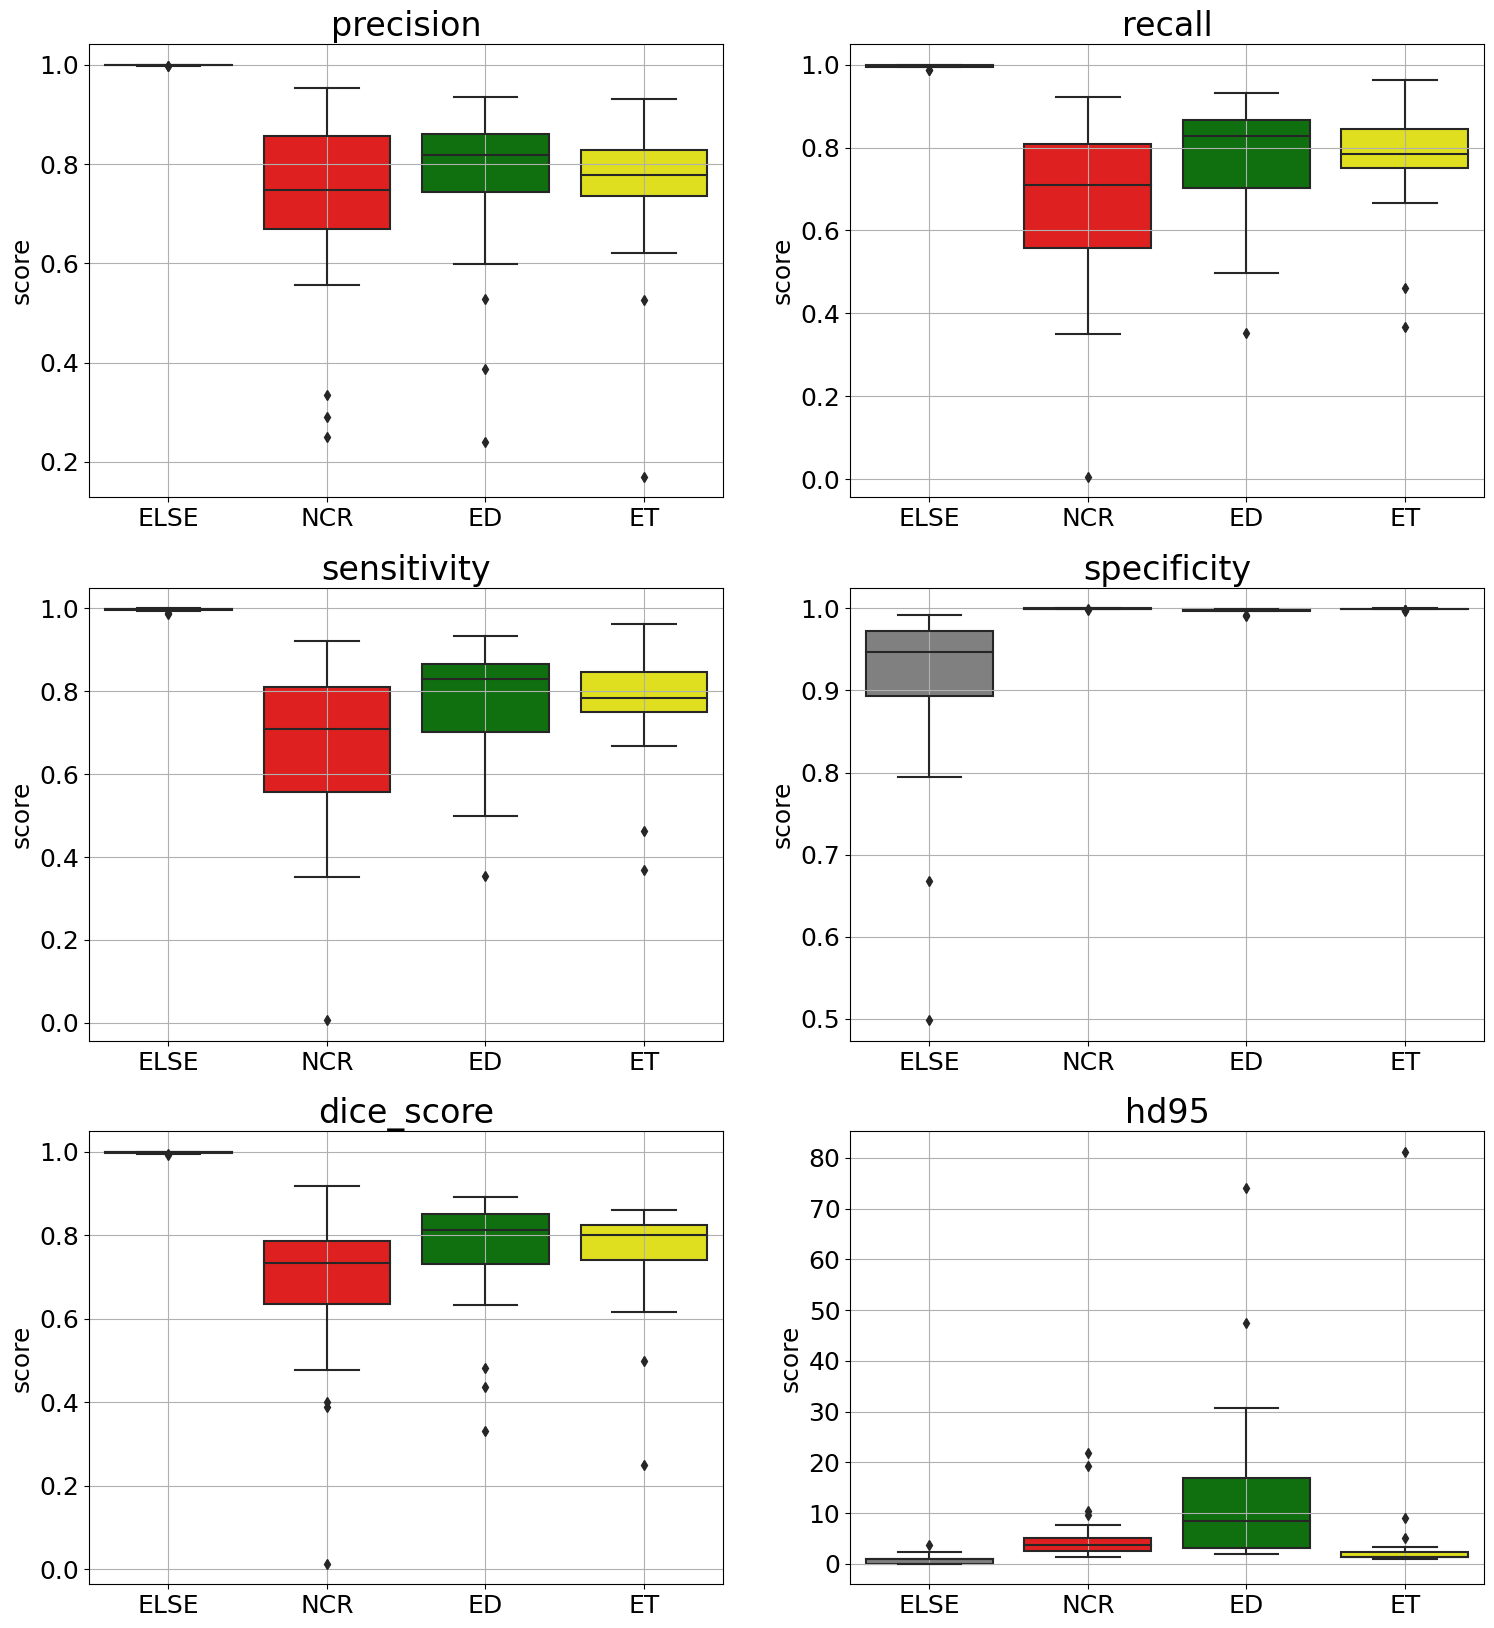

In [75]:
mf_eval.draw_box_plots(val_metrics_dict_upscaled)

Histograms for prediction after scaling back to original size

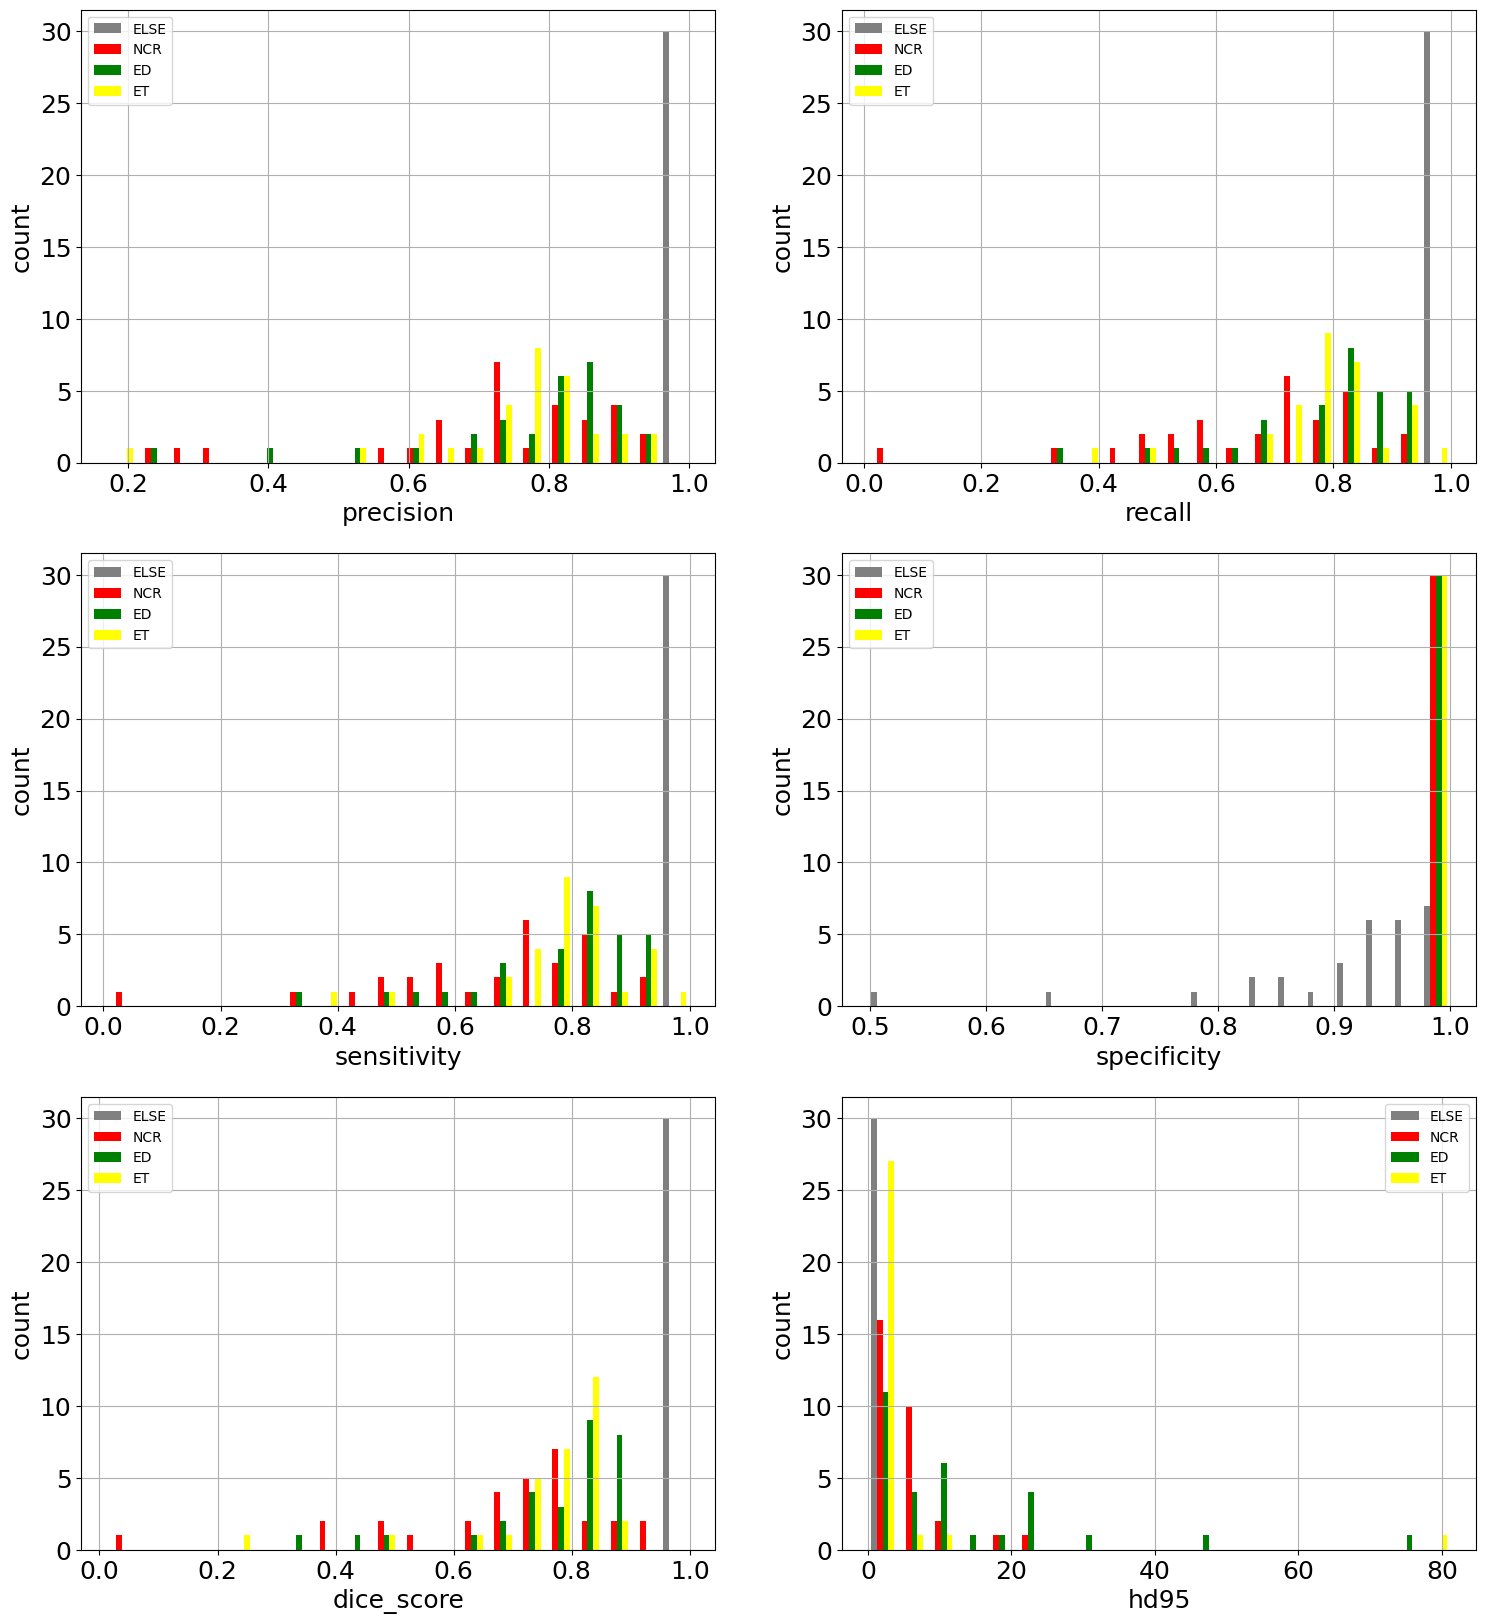

In [76]:
mf_eval.build_histogram(val_metrics_dict_upscaled)

##### Worst Dice Score

In [77]:
# column label id corresponds to the specific segment which got the lowest score: i.e. Label 1 = NCR
low_dice_score_val = mf_eval.get_low_dice_score_images(val_success_files, val_metrics_dict_upscaled, top_n=5)
low_dice_score_val

subj_name  dataset_idx  label_id     score
0  UPENN-GBM-00380           27         1  0.012848
1  UPENN-GBM-00380           27         3  0.248731
2  UPENN-GBM-00013            1         2  0.330524
3  UPENN-GBM-00249           21         1  0.386979
4  UPENN-GBM-00474           29         1  0.400375

##### Worst HD95

In [78]:
high_hd95_val = mf_eval.get_high_hd95_images(val_success_files, val_metrics_dict_upscaled, top_n=5)
high_hd95_val

subj_name  dataset_idx  label_id      score
0  UPENN-GBM-00380           27         3  81.178815
1  UPENN-GBM-00013            1         2  74.092510
2  UPENN-GBM-00140           14         2  47.414131
3  UPENN-GBM-00206           18         2  30.740852
4  UPENN-GBM-00380           27         2  23.832751

##### Plot image with low dice score

In [82]:
low_dice_img = low_dice_score_val.loc[0]['subj_name']

# record start time
start_time = time.time()
image_3d, mask_true_3d, mask_pred_3d, true_class_labels, pred_class_labels = mf_val_inference_upscaled.predict_patient_mask(subj_id=low_dice_img)
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: {:.6f} seconds".format(elapsed_time))

Performing inference on UPENN-GBM-00380
Number of 2d slices for patient 146
Elapsed time: 15.101030 seconds


100%|██████████| 1.46G/1.46G [00:47<00:00, 30.4MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 735/735 [00:08<00:00, 88.71it/s]


Slice 55


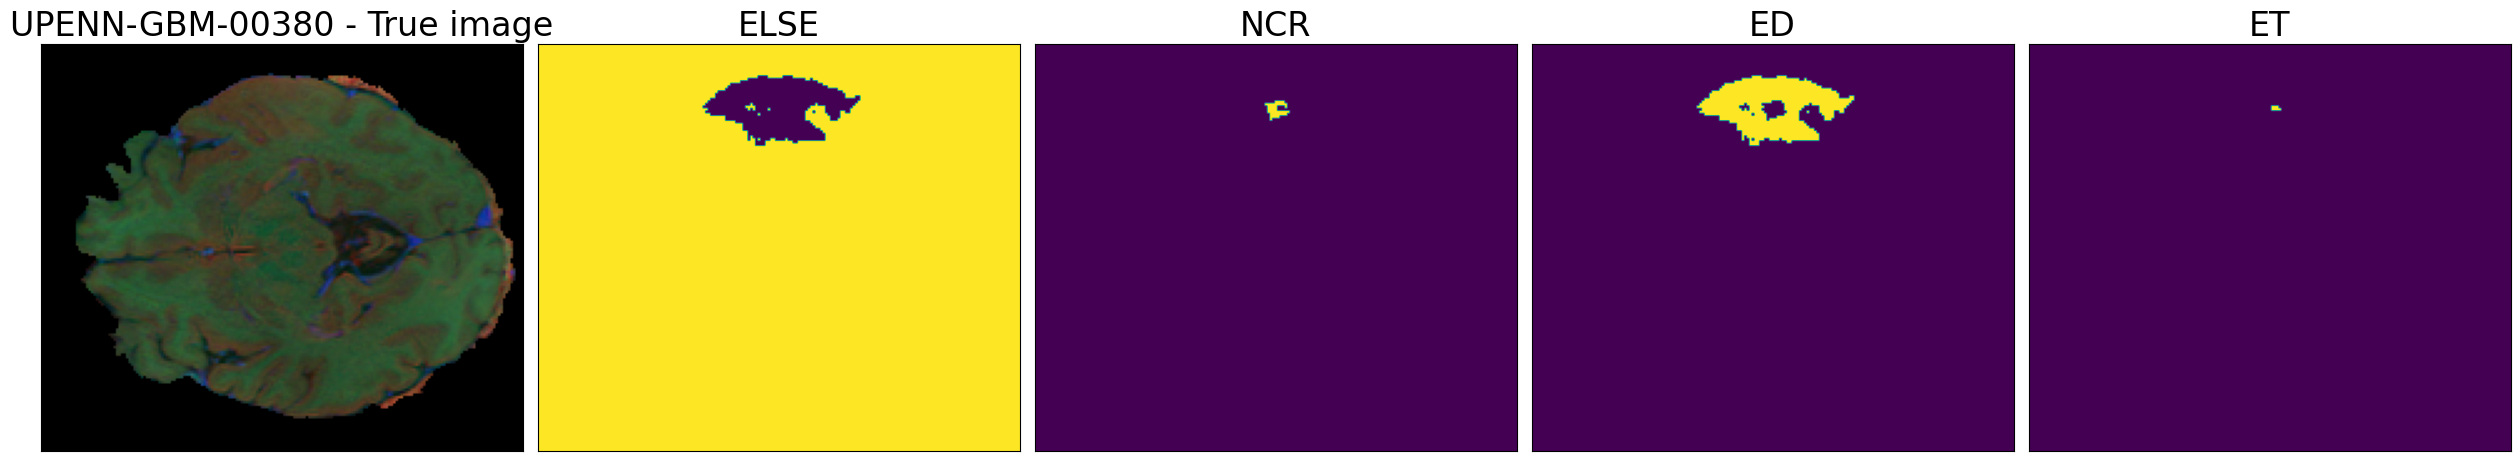

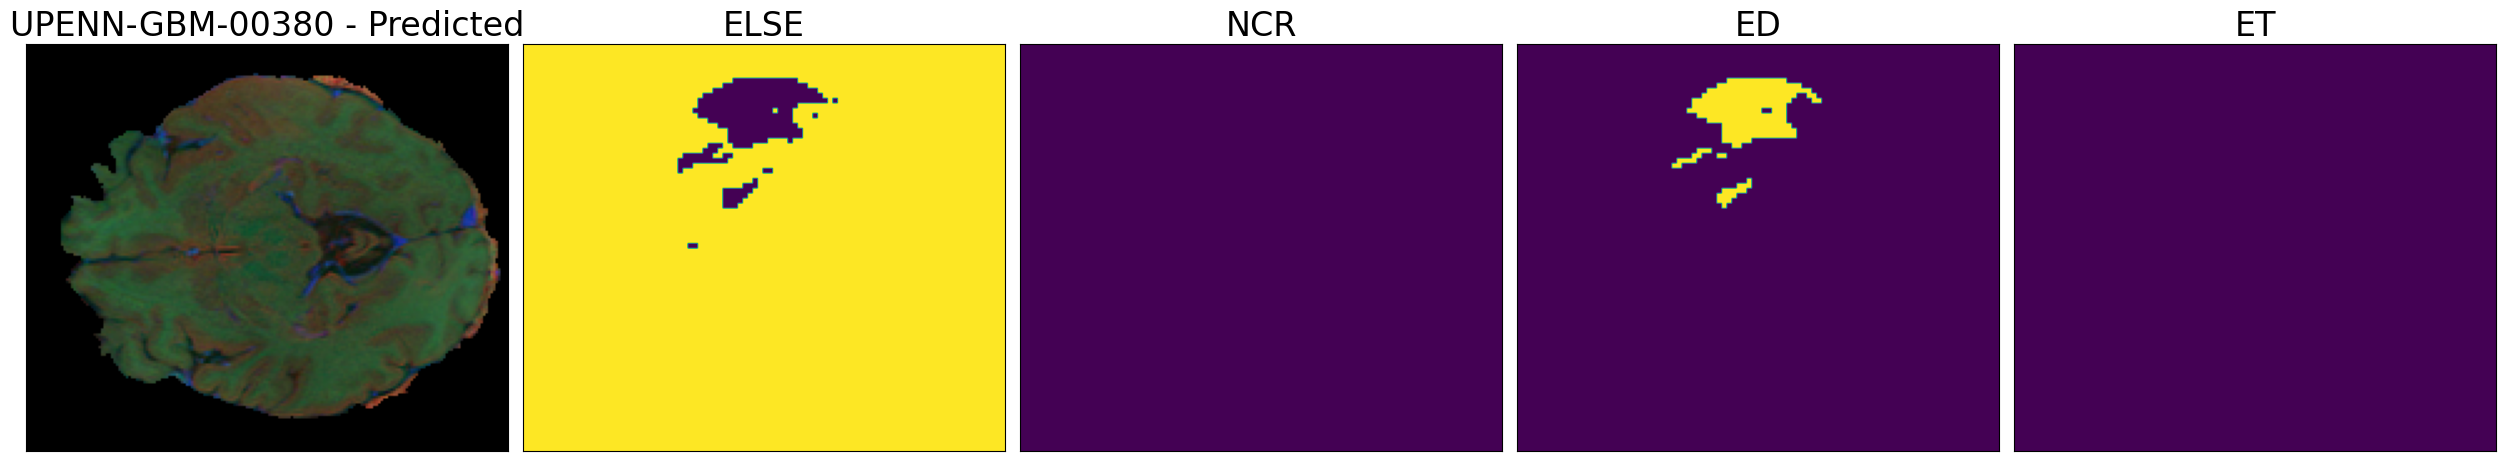

In [80]:
# load annotated file
actual_file = data_handler.load_mri(low_dice_img, mri_type=MriType.ANNOTATED_REDUCED)

# get largest tumor slice for visualization
slice_idx = mri_common.get_largest_tumor_slice_idx(actual_file)[0]

print("Slice", slice_idx)
mf_utils.plot_mask_labels(class_labels = true_class_labels,
             pixel_values = image_3d[slice_idx, :, :, :],
             mask_labels = mask_true_3d[:, slice_idx, :, :],
             title = f"{low_dice_img} - True image",)

mf_utils.plot_mask_labels(class_labels = pred_class_labels,
             pixel_values = image_3d[slice_idx, :, :, :],
             mask_labels = mask_pred_3d[:, slice_idx, :, :],
             title = f"{low_dice_img} - Predicted",)

input segmentation shape: (163, 193)
pred segmentation shape: (163, 193)


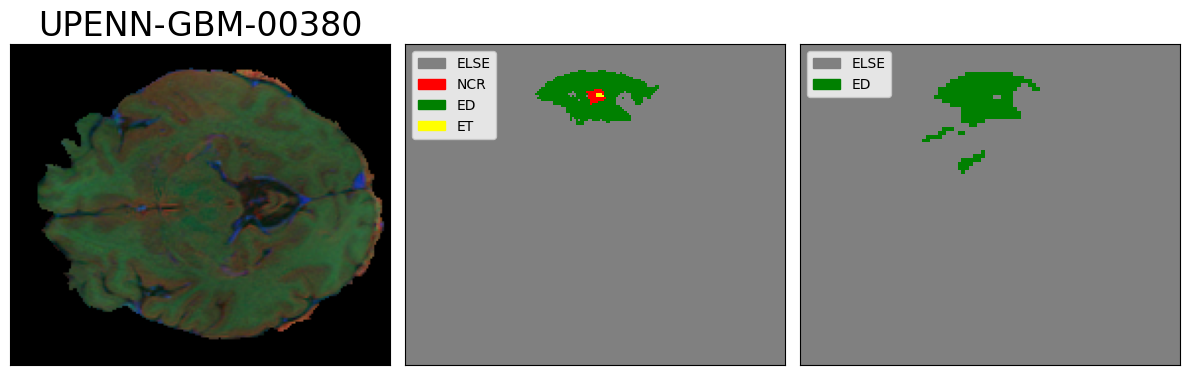

In [81]:
# compare segmentation
input_segmentation = mf_utils.mask_to_segmentation(mask_labels=mask_true_3d[:, slice_idx, :, :], class_labels=true_class_labels)
pred_segmentation = mf_utils.mask_to_segmentation(mask_labels=mask_pred_3d[:, slice_idx, :, :], class_labels=pred_class_labels)
print("input segmentation shape:", input_segmentation.shape)
print("pred segmentation shape:", pred_segmentation.shape)

# cut the 3d image using the slice
mf_utils.plot_segmentation_comparison(
            input_pixel_values=image_3d[slice_idx, :, :, :],
            input_segmentation=input_segmentation,
            pred_segmentation=pred_segmentation,
            title=low_dice_img, loc="upper left")

#### 4.2.7 Make prediction ensembles

##### make and save model predictions (need to load corresponding models first)

In [83]:
# Obtain all test subjects
test_subjs = mf_utils.get_all_subj_ids(data_dir=data_dir_test)
print("total test data", len(test_subjs))
print("first 5 test subjects")
test_subjs[:5]

total test data 29
first 5 test subjects


['UPENN-GBM-00002',
 'UPENN-GBM-00014',
 'UPENN-GBM-00026',
 'UPENN-GBM-00059',
 'UPENN-GBM-00062']

In [91]:
# Change if val or test
DATASET_DIR = data_dir_val # data_dir_test
SUBJECT_LIST = val_subjs # test_subjs

In [ ]:
### make and save predictions (need to run multiple times)
# define names
pred_orientation = '_depth_2x'
# pred_orientation = '_cross_side_2x'
# pred_orientation = '_cross_front_2x'

folder = '/new2_pred'

## loop subjects and make predictions
## do the same for both test and validation

# define a new maskformerinference class for the test dataset
mf_ensemble_inference =MaskFormerInference(data_dir=DATASET_DIR,
                                              model=model,
                                              processor=processor,
                                              upscaled_transform=predict_transform,
                                              orig_transform=org_transform,
                                              scale_to_orig_size=True,
                                              orig_dim=orig_dim)


for subj_id in val_subjs:
    prediction_val_cur = mf_ensemble_inference.predict_patient_mask(subj_id)
    # save prediction mask (index 2)
    mask_pred_3d = prediction_val_cur[2]

    # save predictions
    file_name = subj_id + pred_orientation
    data_handler.save_torch(file_name=file_name, data=mask_pred_3d, train_dir_prefix = TRAIN_DIR_PREFIX+folder)

mri directory /content/data/images_annot_reduced_norm_2d/val/depth
Performing inference on UPENN-GBM-00008
Number of 2d slices for patient 146
Performing inference on UPENN-GBM-00013
Number of 2d slices for patient 146
Performing inference on UPENN-GBM-00020
Number of 2d slices for patient 146
Performing inference on UPENN-GBM-00030
Number of 2d slices for patient 146
Performing inference on UPENN-GBM-00033
Number of 2d slices for patient 146
Performing inference on UPENN-GBM-00054
Number of 2d slices for patient 146
Performing inference on UPENN-GBM-00075
Number of 2d slices for patient 146
Performing inference on UPENN-GBM-00086
Number of 2d slices for patient 146
Performing inference on UPENN-GBM-00100
Number of 2d slices for patient 146
Performing inference on UPENN-GBM-00101
Number of 2d slices for patient 146
Performing inference on UPENN-GBM-00105
Number of 2d slices for patient 146
Performing inference on UPENN-GBM-00118
Number of 2d slices for patient 146
Performing inference 

In [ ]:
# verify shape of last prediction (should be the dimension expected)
mask_pred_3d.shape

In [ ]:
# obtain ground truth mask and orignal images and save it
# currently, this needs to be computed on the depth orientation to be consistent with data loading below
# don't run on the other orientations

folder = '/new2_pred'

org_transform = A.Compose([
    A.Normalize(mean=mf_utils.ADE_MEAN, std=mf_utils.ADE_STD),
])

mf_eval = MaskFormerEvaluation()

mf_inference_org = MaskFormerInference(data_dir=DATASET_DIR,
                                            model=model,
                                            processor=processor,
                                            upscaled_transform=org_transform,
                                            scale_to_orig_size=False)
for subj_id in SUBJECT_LIST:
    prediction_cur = mf_inference_org.predict_patient_mask(subj_id)
    # index 1 is the ground truth mask
    mask_true_3d = prediction_cur[1]

    # save predictions
    file_name = subj_id + "_ground_truth"
    data_handler.save_torch(file_name=file_name, data=mask_true_3d, train_dir_prefix = TRAIN_DIR_PREFIX+folder)

    image_3d = prediction_cur[0]
    # print(image_3d.dtype)
    # save predictions
    orig_file_name = subj_id + "_image"
    data_handler.save_torch(file_name=orig_file_name, data=image_3d, train_dir_prefix = TRAIN_DIR_PREFIX+folder)

##### load and integrate model predictions

In [89]:
d1 = len(mri_common.SEGMENTS) # number of labels
d2 = mri_common.SLICE_TOTAL["DEPTH"] # n depth
d3 = mri_common.SLICE_TOTAL["CROSS_SIDE"] # n side
d4 = mri_common.SLICE_TOTAL["CROSS_FRONT"] # n front
d1, d2, d3, d4

(4, 146, 163, 193)

In [ ]:
# select validation or test subjects
subj_list = list(SUBJECT_LIST)
len(subj_list)

In [ ]:
# load true mask and all predictions
# folder = '/predictions_new2'
folder = '/new2_pred'

# mask_depth_512 = '_depth_512'
# mask_depth_2x = '_depth_2x'
# mask_cross_side_2x = '_cross_side_2x'
image_true = '_image'
mask_true = '_ground_truth'
mask_depth_2x_v1 = '_depth_2x_v1'
mask_cross_side_2x_v1 = '_cross_side_2x_v1'
mask_cross_front_2x_v1 = '_cross_front_2x_v1'
mask_depth_2x = '_depth_2x'
mask_cross_side_2x = '_cross_side_2x'
mask_cross_front_2x = '_cross_front_2x'

# orientation_list = [mask_depth_512, mask_depth_2x, mask_cross_side_2x]
orientation_list = [mask_depth_2x, mask_cross_side_2x, mask_cross_front_2x]
# orientation_list = [mask_depth_2x_v1, mask_cross_side_2x_v1, mask_cross_front_2x_v1,
#                     mask_depth_2x, mask_cross_side_2x, mask_cross_front_2x]

masks_3d_true = np.zeros((len(subj_list), d1, d2, d3, d4), dtype='uint8')
image_3d_true = np.zeros((len(subj_list), 3, d2, d3, d4), dtype='float16')
masks_3d_pred = np.zeros((len(subj_list), len(orientation_list), d1, d2, d3, d4), dtype='uint8')

for isubj, subj in enumerate(subj_list):
    print('loading predcited and true masks for subject', subj)
    file_name = subj + mask_true
    stream_data = data_handler.load_from_stream(file_name, TRAIN_DIR_PREFIX+folder)
    masks_3d_true[isubj,:,:,:,:] = torch.load(stream_data)/255.0

    # file_name = subj + image_true
    # stream_data = data_handler.load_from_stream(file_name, TRAIN_DIR_PREFIX+folder)
    # image_3d_true[isubj,:,:,:,:] = torch.load(stream_data).transpose(1,0,2,3)/255.0

    file_name = subj + image_true
    stream_data = data_handler.load_from_stream(file_name, TRAIN_DIR_PREFIX+folder)
    image_3d_true[isubj,:,:,:,:] = torch.load(stream_data).transpose(1,0,2,3)

    for idx in range(len(orientation_list)):
        file_name = subj + orientation_list[idx]
        stream_data = data_handler.load_from_stream(file_name, TRAIN_DIR_PREFIX+folder)
        temp_data = torch.load(stream_data)
        if "side" in orientation_list[idx]:
            masks_3d_pred[isubj,idx,:,:,:,:] = temp_data.transpose(0,3,1,2)/255.0
        elif "front" in orientation_list[idx]:
            masks_3d_pred[isubj,idx,:,:,:,:] = temp_data.transpose(0,3,2,1)/255.0
        else:
            masks_3d_pred[isubj,idx,:,:,:,:] = temp_data/255.0

loading predcited and true masks for subject UPENN-GBM-00008
loading predcited and true masks for subject UPENN-GBM-00013
loading predcited and true masks for subject UPENN-GBM-00020
loading predcited and true masks for subject UPENN-GBM-00030
loading predcited and true masks for subject UPENN-GBM-00033
loading predcited and true masks for subject UPENN-GBM-00054
loading predcited and true masks for subject UPENN-GBM-00075
loading predcited and true masks for subject UPENN-GBM-00086
loading predcited and true masks for subject UPENN-GBM-00100
loading predcited and true masks for subject UPENN-GBM-00101
loading predcited and true masks for subject UPENN-GBM-00105
loading predcited and true masks for subject UPENN-GBM-00118
loading predcited and true masks for subject UPENN-GBM-00124
loading predcited and true masks for subject UPENN-GBM-00131
loading predcited and true masks for subject UPENN-GBM-00140
loading predcited and true masks for subject UPENN-GBM-00144
loading predcited and tr

##### use TC, WT, ET categories

In [ ]:
### convert categories from NCR, ED, ET to TC, WT and ET.
CONVERT_PRED = True

if CONVERT_PRED == True:
    masks_3d_pred[:,:,2,:,:,:] += masks_3d_pred[:,:,1,:,:,:] + masks_3d_pred[:,:,3,:,:,:]
    masks_3d_pred[:,:,1,:,:,:] += masks_3d_pred[:,:,3,:,:,:]

    masks_3d_true[:,2,:,:,:] += masks_3d_true[:,1,:,:,:] + masks_3d_true[:,3,:,:,:]
    masks_3d_true[:,1,:,:,:] += masks_3d_true[:,3,:,:,:]


In [ ]:
# obtain a new mask by aggregation of predicted masks

# compuate average
masks_3d_agg = np.mean(masks_3d_pred, axis=1)

# Define the two values you want to round to
rounded_value_1 = 0
rounded_value_2 = 1

# Set the condition for rounding
condition = masks_3d_agg >= (rounded_value_1+rounded_value_2)/2
# condition = masks_3d_agg >= 0.1

# Use numpy.where() to round values to the specified values based on the condition
masks_3d_agg = np.where(condition, rounded_value_2, rounded_value_1)
masks_3d_agg = masks_3d_agg.astype('uint8')

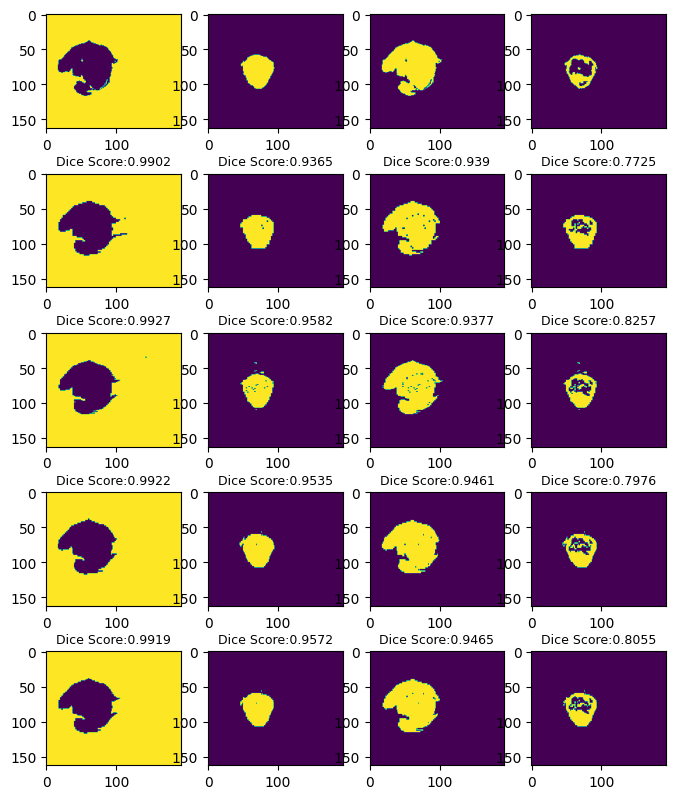

In [ ]:
# isubj_test = 0
# idepth = 70
isubj_test = 5
idepth = 90
my_fontsize = 9

nrows = len(orientation_list) + 1 + 1
ncols = 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols, 2*nrows))

for ilabel in range(ncols):
    axes[0,ilabel].imshow(masks_3d_true[isubj_test,ilabel,idepth,:,:])
    for i_ori in range(len(orientation_list)):
        dice_score = metrics.calc_dice_score(masks_3d_pred[isubj_test,i_ori,ilabel,idepth,:,:], masks_3d_true[isubj_test,ilabel,idepth,:,:])
        axes[i_ori+1, ilabel].imshow(masks_3d_pred[isubj_test,i_ori,ilabel,idepth,:,:])
        axes[i_ori+1, ilabel].set_title('Dice Score:'+str(round(dice_score,4)), fontsize=my_fontsize)

    dice_score = metrics.calc_dice_score(masks_3d_agg[isubj_test,ilabel,idepth,:,:], masks_3d_true[isubj_test,ilabel,idepth,:,:])
    axes[nrows-1,ilabel].imshow(masks_3d_agg[isubj_test,ilabel,idepth,:,:])
    axes[nrows-1,ilabel].set_title('Dice Score:'+str(round(dice_score,4)), fontsize=my_fontsize)



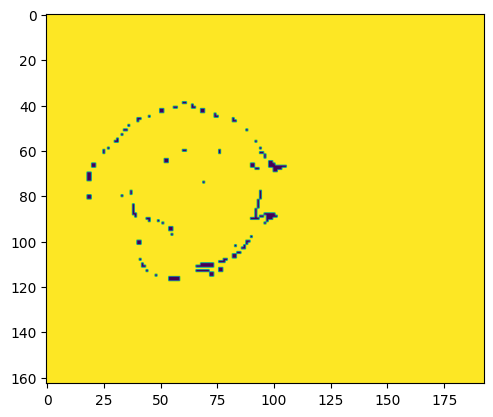

In [ ]:
temp_mask = masks_3d_agg[isubj_test,0,idepth,:,:] + masks_3d_agg[isubj_test,2,idepth,:,:]
plt.imshow(temp_mask)

In [ ]:
# refine aggregated mask

REFINE_AGG_MASK = True

if REFINE_AGG_MASK == True:
    temp_mask = masks_3d_agg[:,0,:,:,:] + masks_3d_agg[:,2,:,:,:]
    zero_elements_mask = (temp_mask == 0)

    for idx1 in range(len(subj_list)):
        print('working on subj No.',idx1)
        for idx2 in range(d2):
            for idx3 in range(d3):
                for idx4 in range(d4):
                    if zero_elements_mask[idx1,idx2,idx3,idx4]:
                        # fill in TC when there is at least one prediction
                        if masks_3d_pred[idx1,:,1,idx2,idx3,idx4].sum() >= 1:
                            masks_3d_agg[idx1,1,idx2,idx3,idx4] = 1
                        # fill in WT when there is at least one prediction
                        if masks_3d_pred[idx1,:,2,idx2,idx3,idx4].sum() >= 1:
                            masks_3d_agg[idx1,2,idx2,idx3,idx4] = 1


working on subj No. 0
working on subj No. 1
working on subj No. 2
working on subj No. 3
working on subj No. 4
working on subj No. 5
working on subj No. 6
working on subj No. 7
working on subj No. 8
working on subj No. 9
working on subj No. 10
working on subj No. 11
working on subj No. 12
working on subj No. 13
working on subj No. 14
working on subj No. 15
working on subj No. 16
working on subj No. 17
working on subj No. 18
working on subj No. 19
working on subj No. 20
working on subj No. 21
working on subj No. 22
working on subj No. 23
working on subj No. 24
working on subj No. 25
working on subj No. 26
working on subj No. 27
working on subj No. 28
working on subj No. 29


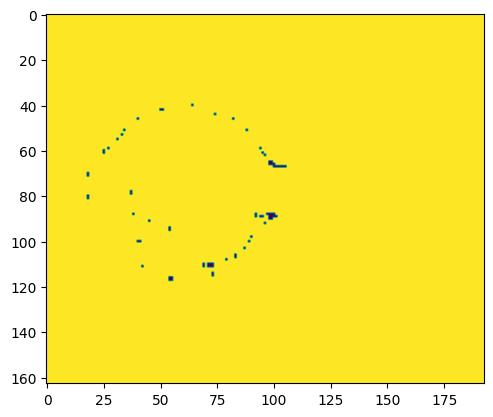

In [ ]:
# check prediction after refinement
temp_mask = masks_3d_agg[isubj_test,0,idepth,:,:] + masks_3d_agg[isubj_test,2,idepth,:,:]
plt.imshow(temp_mask)

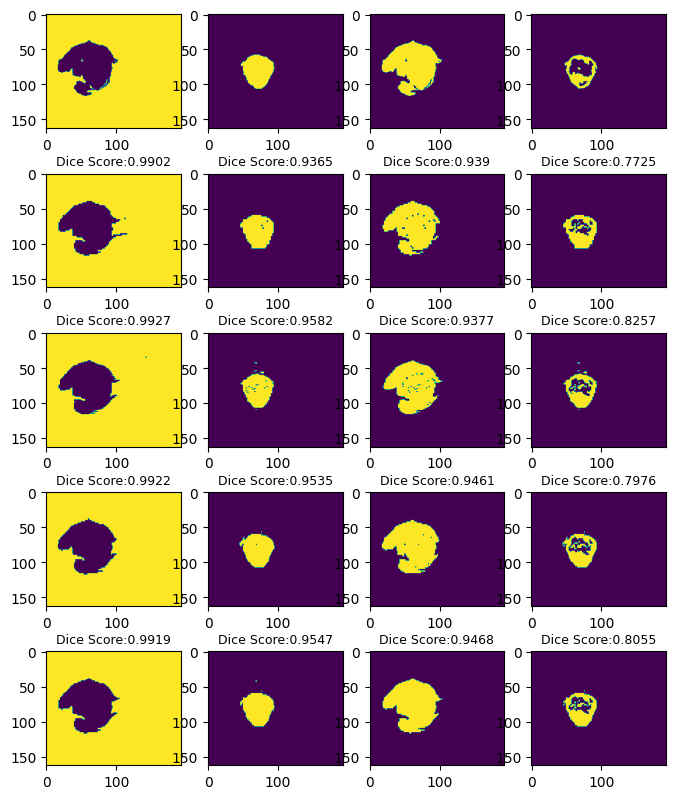

In [ ]:
# check prediction after refinement

# isubj_test = 0
# idepth = 70
isubj_test = 5
idepth = 90
my_fontsize = 9

nrows = len(orientation_list) + 1 + 1
ncols = 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols, 2*nrows))

for ilabel in range(ncols):
    axes[0,ilabel].imshow(masks_3d_true[isubj_test,ilabel,idepth,:,:])
    for i_ori in range(len(orientation_list)):
        dice_score = metrics.calc_dice_score(masks_3d_pred[isubj_test,i_ori,ilabel,idepth,:,:], masks_3d_true[isubj_test,ilabel,idepth,:,:])
        axes[i_ori+1, ilabel].imshow(masks_3d_pred[isubj_test,i_ori,ilabel,idepth,:,:])
        axes[i_ori+1, ilabel].set_title('Dice Score:'+str(round(dice_score,4)), fontsize=my_fontsize)

    dice_score = metrics.calc_dice_score(masks_3d_agg[isubj_test,ilabel,idepth,:,:], masks_3d_true[isubj_test,ilabel,idepth,:,:])
    axes[nrows-1,ilabel].imshow(masks_3d_agg[isubj_test,ilabel,idepth,:,:])
    axes[nrows-1,ilabel].set_title('Dice Score:'+str(round(dice_score,4)), fontsize=my_fontsize)


In [ ]:
# test subject
val_subjs[isubj_test]

'UPENN-GBM-00054'

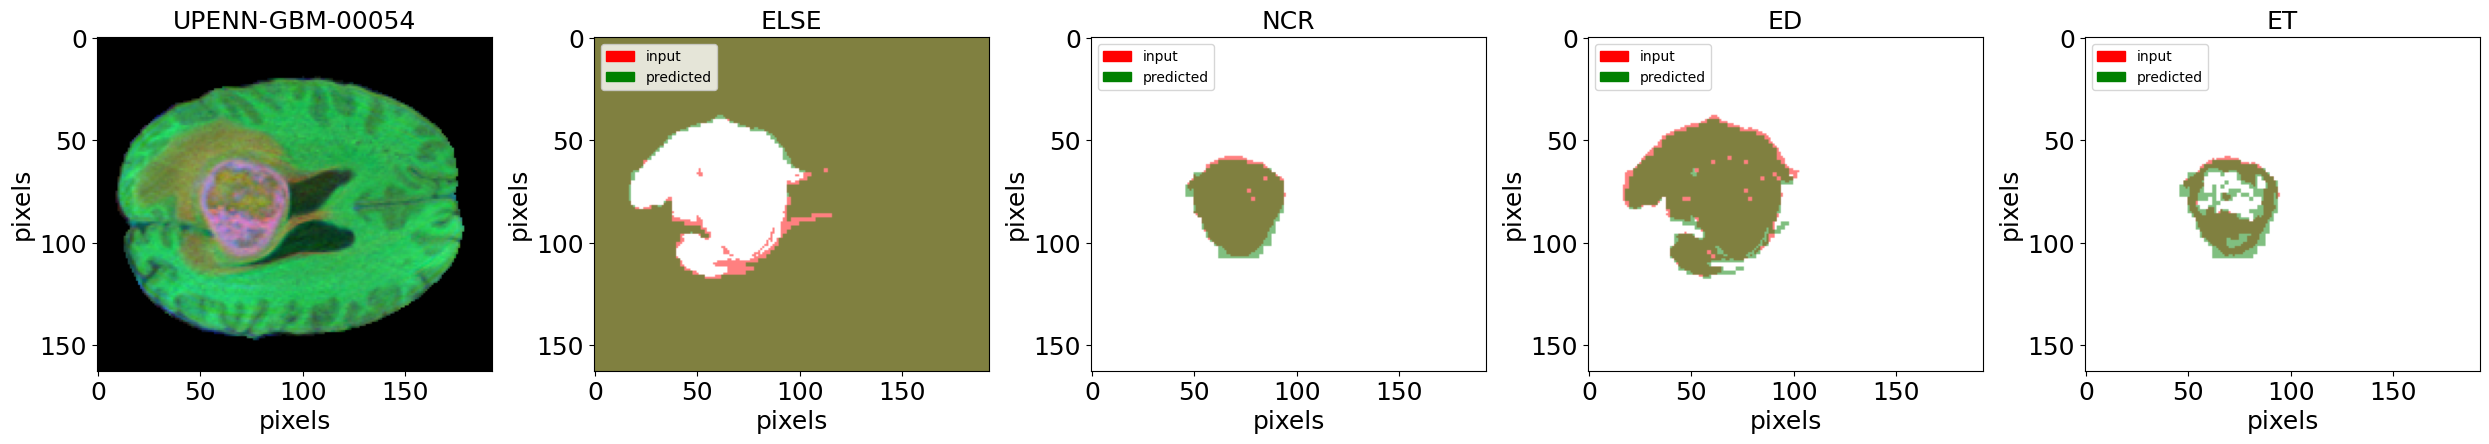

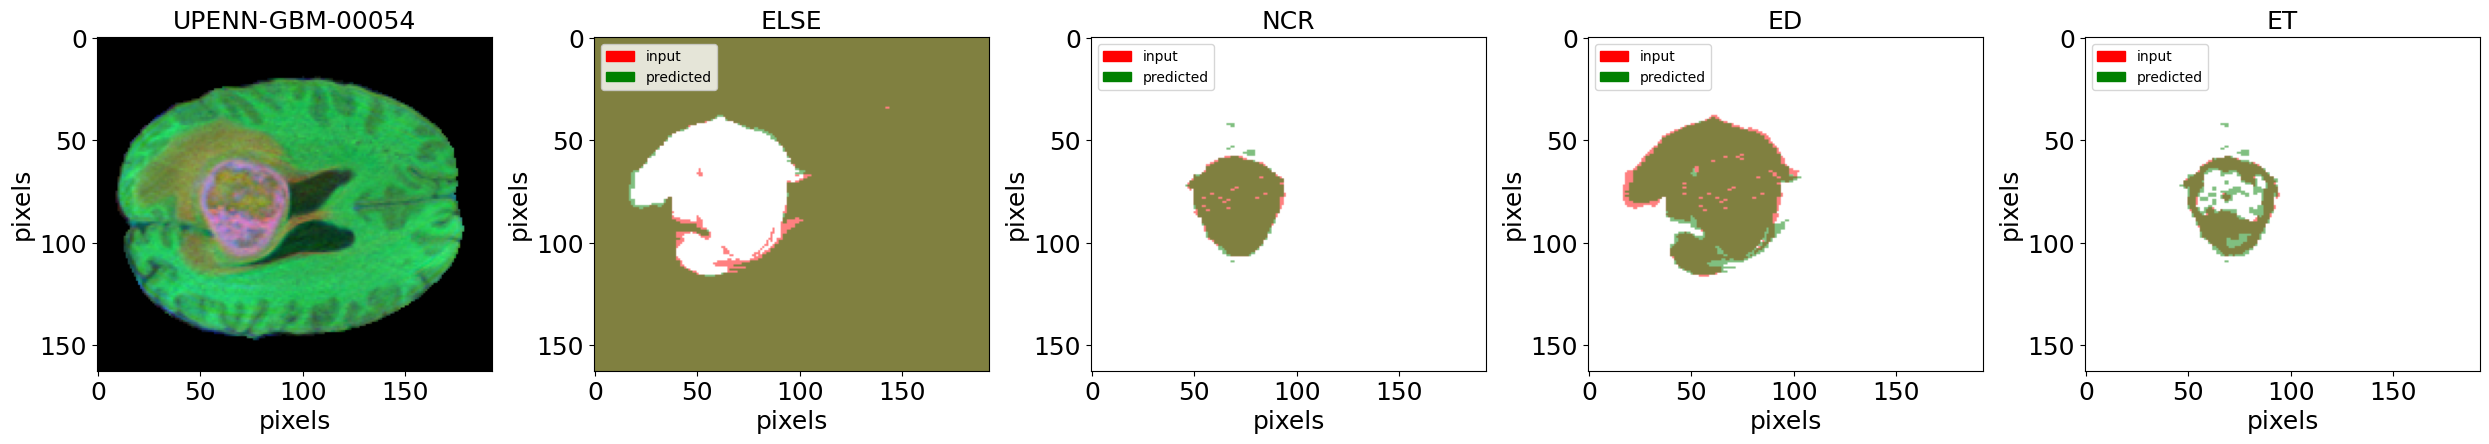

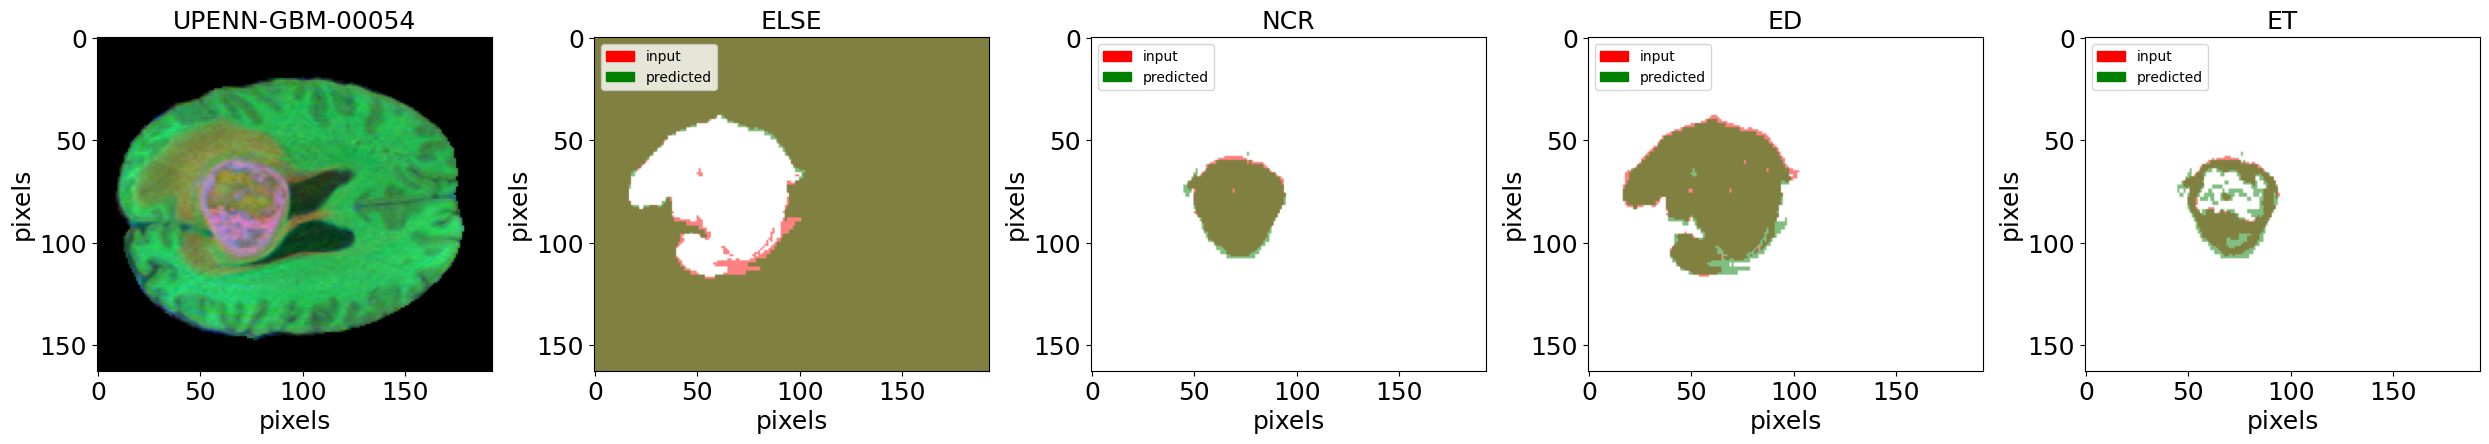

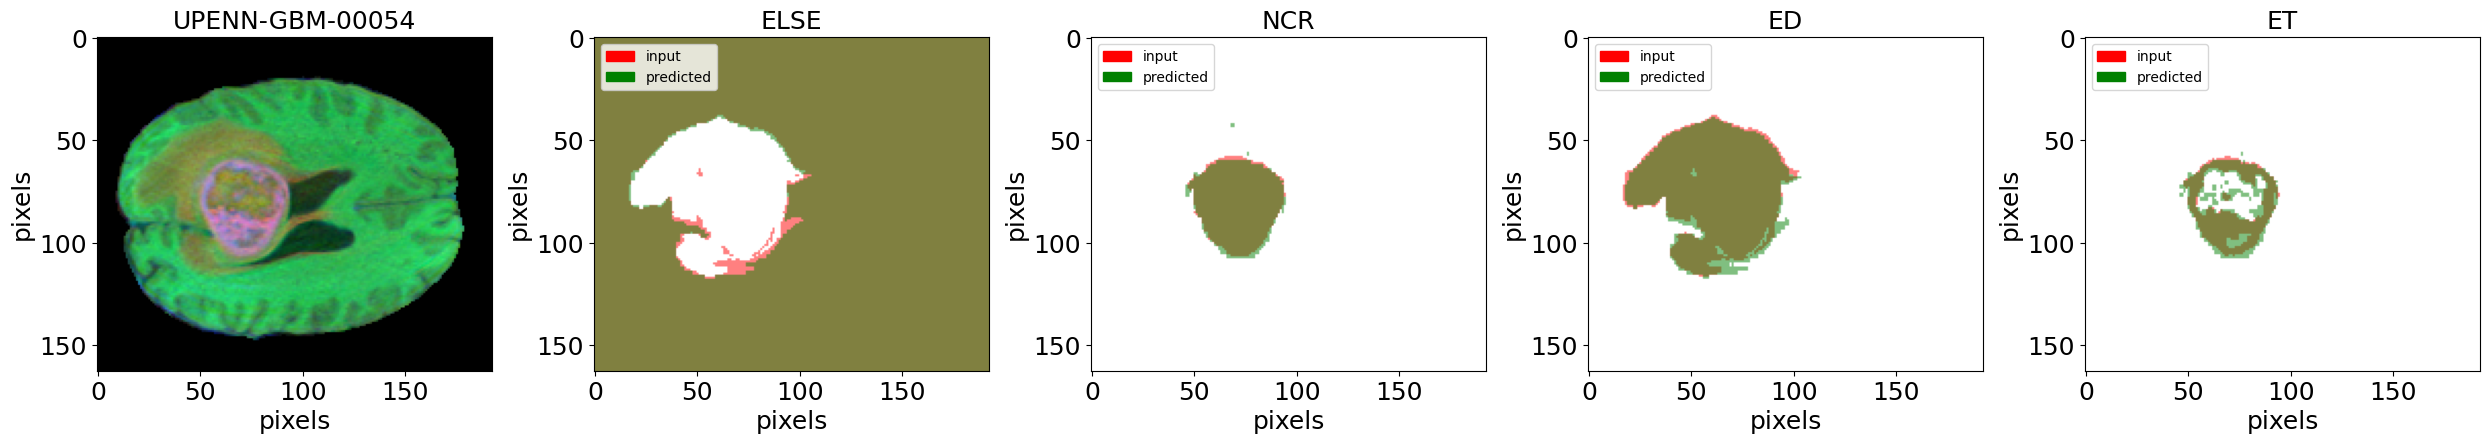

In [ ]:
for idx in range(len(orientation_list)):
    mf_utils.plot_mask_comparison(input_class_labels=[0,1,2,3],
                        pred_class_labels=[0,1,2,3],
                        input_pixel_values=image_3d_true[isubj_test,:,idepth,:,:],
                        input_mask_labels=masks_3d_true[isubj_test,:,idepth,:,:],
                        pred_mask_labels=masks_3d_pred[isubj_test,idx,:,idepth,:,:],
                        title=val_subjs[isubj_test])

mf_utils.plot_mask_comparison(input_class_labels=[0,1,2,3],
                        pred_class_labels=[0,1,2,3],
                        input_pixel_values=image_3d_true[isubj_test,:,idepth,:,:],
                        input_mask_labels=masks_3d_true[isubj_test,:,idepth,:,:],
                        pred_mask_labels=masks_3d_agg[isubj_test,:,idepth,:,:],
                        title=val_subjs[isubj_test])




##### calculate scores

In [ ]:
# measure similarity between predictions and ground truth
dice_score_results = np.zeros((len(orientation_list)+1, len(subj_list), 4))

for isubj_test in range(len(subj_list)):
    print('Subject',subj_list[isubj_test])
    for icat in range(4):
        # print('Subject',subj_list[isubj_test],'class',id2label[icat])

        for imodel in range(len(orientation_list)):
            dice_score = metrics.calc_dice_score(masks_3d_pred[isubj_test,imodel,icat,:,:,:], masks_3d_true[isubj_test,icat,:,:,:])
            dice_score_results[imodel, isubj_test,icat] = dice_score
            # print('Dice Score model 1 '+str(round(dice_score,4)))

        dice_score = metrics.calc_dice_score(masks_3d_agg[isubj_test,icat,:,:,:], masks_3d_true[isubj_test,icat,:,:,:])
        dice_score_results[len(orientation_list), isubj_test,icat] = dice_score
        # print('Dice Score model all '+str(round(dice_score,4)))



Subject UPENN-GBM-00008
Subject UPENN-GBM-00013
Subject UPENN-GBM-00020
Subject UPENN-GBM-00030
Subject UPENN-GBM-00033
Subject UPENN-GBM-00054
Subject UPENN-GBM-00075
Subject UPENN-GBM-00086
Subject UPENN-GBM-00100
Subject UPENN-GBM-00101
Subject UPENN-GBM-00105
Subject UPENN-GBM-00118
Subject UPENN-GBM-00124
Subject UPENN-GBM-00131
Subject UPENN-GBM-00140
Subject UPENN-GBM-00144
Subject UPENN-GBM-00151
Subject UPENN-GBM-00205
Subject UPENN-GBM-00206
Subject UPENN-GBM-00217
Subject UPENN-GBM-00240
Subject UPENN-GBM-00249
Subject UPENN-GBM-00253
Subject UPENN-GBM-00259
Subject UPENN-GBM-00261
Subject UPENN-GBM-00264
Subject UPENN-GBM-00284
Subject UPENN-GBM-00380
Subject UPENN-GBM-00439
Subject UPENN-GBM-00474


###### box plots

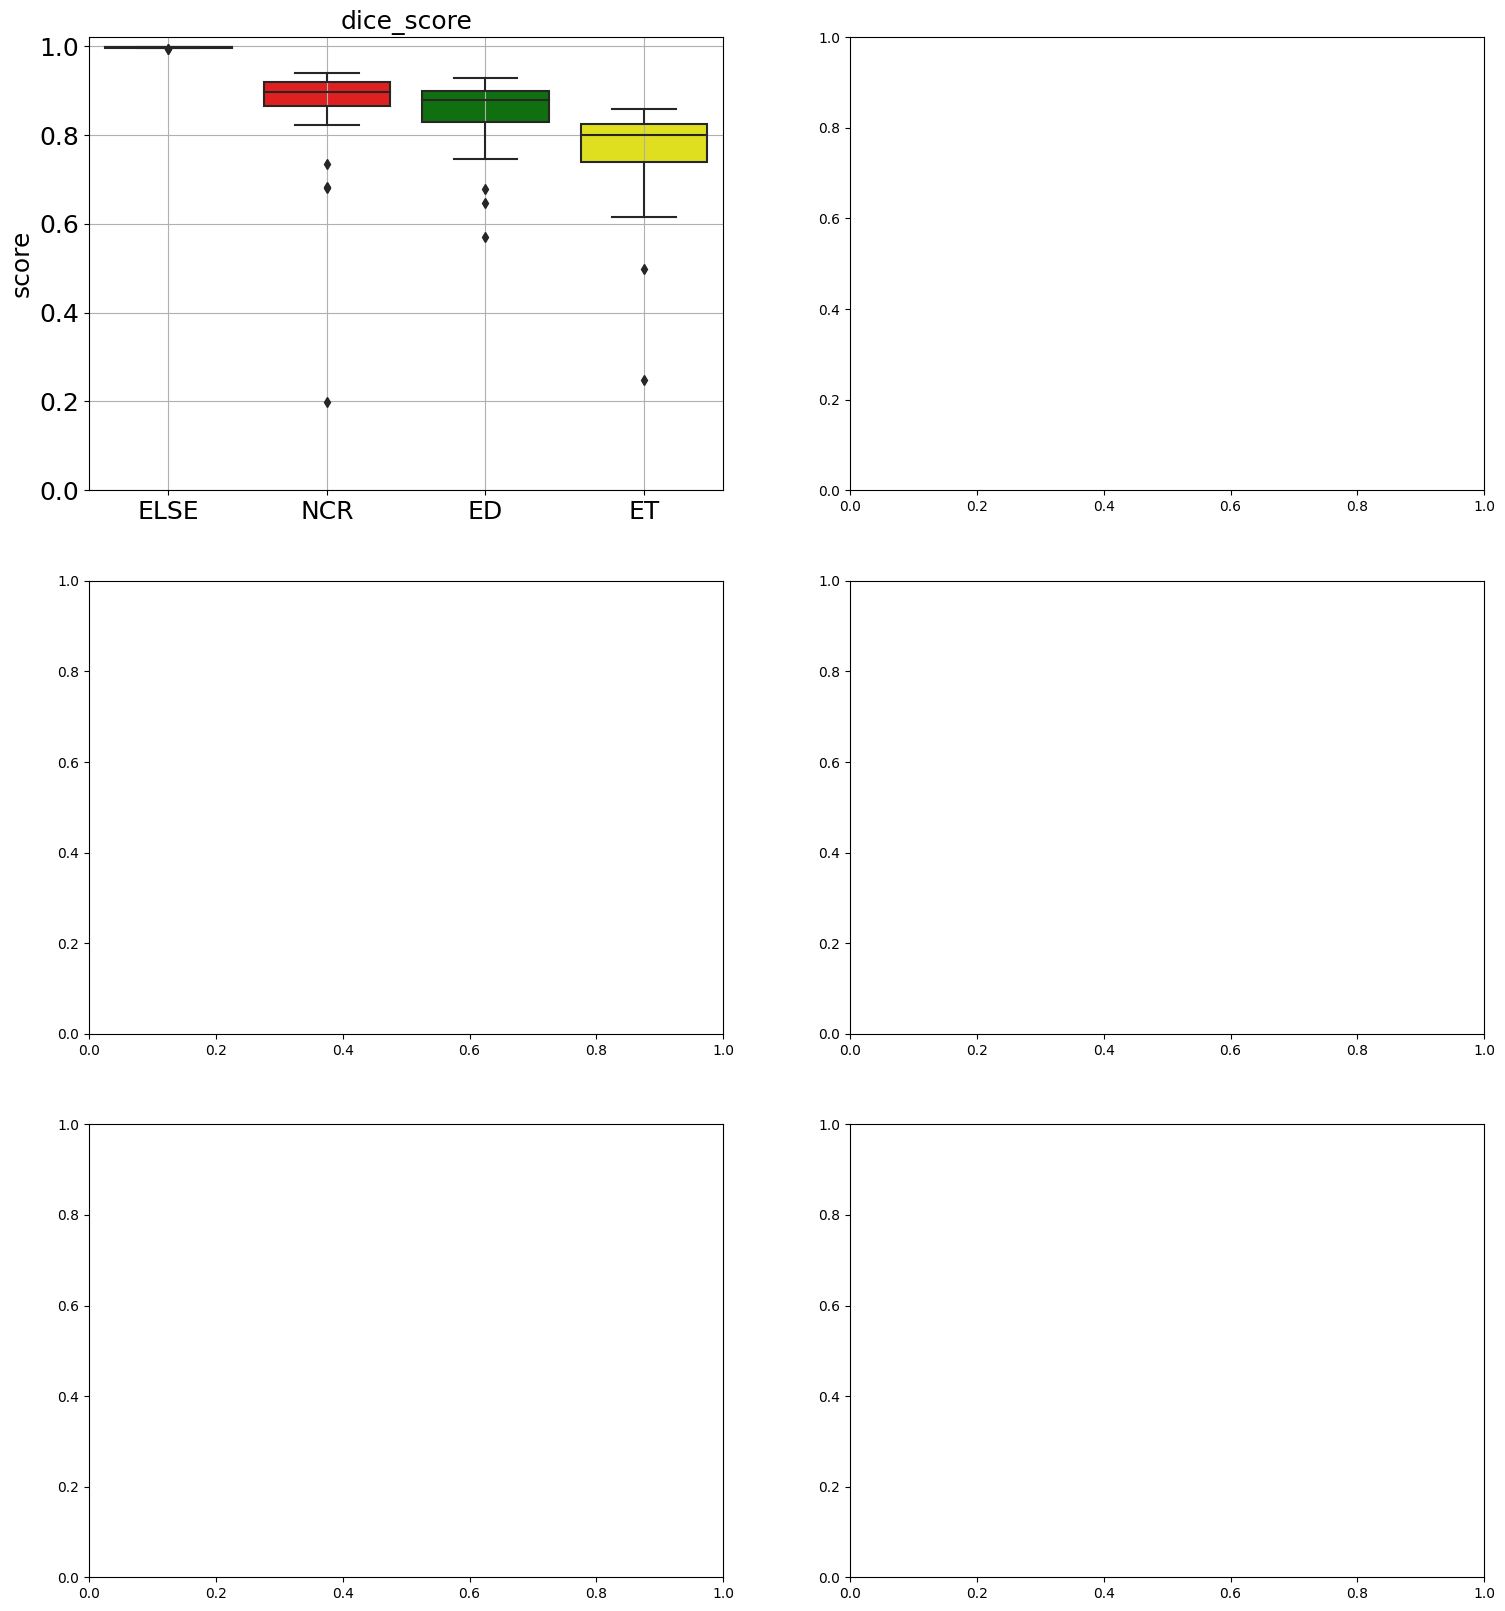

0.7588


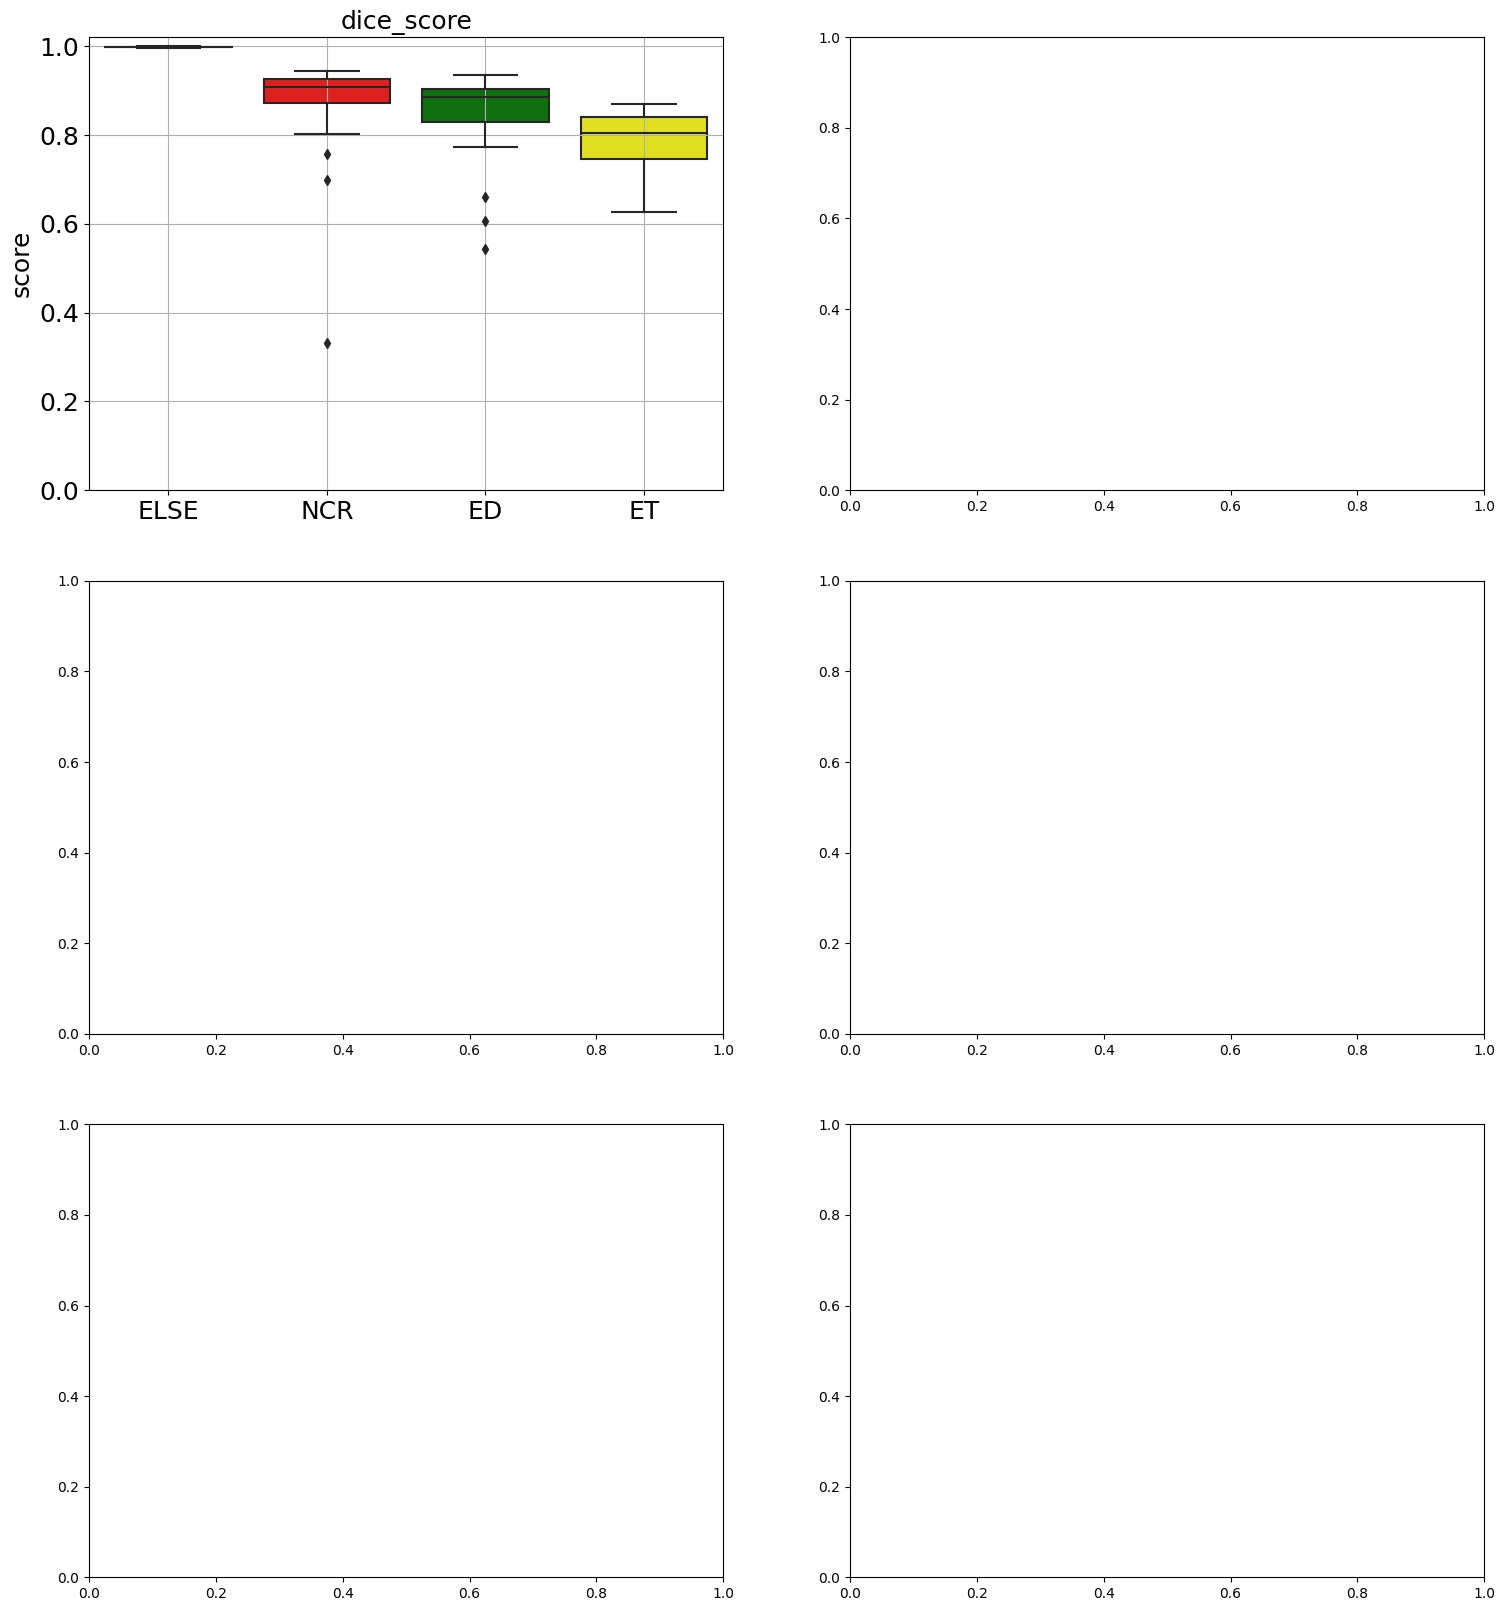

0.7876


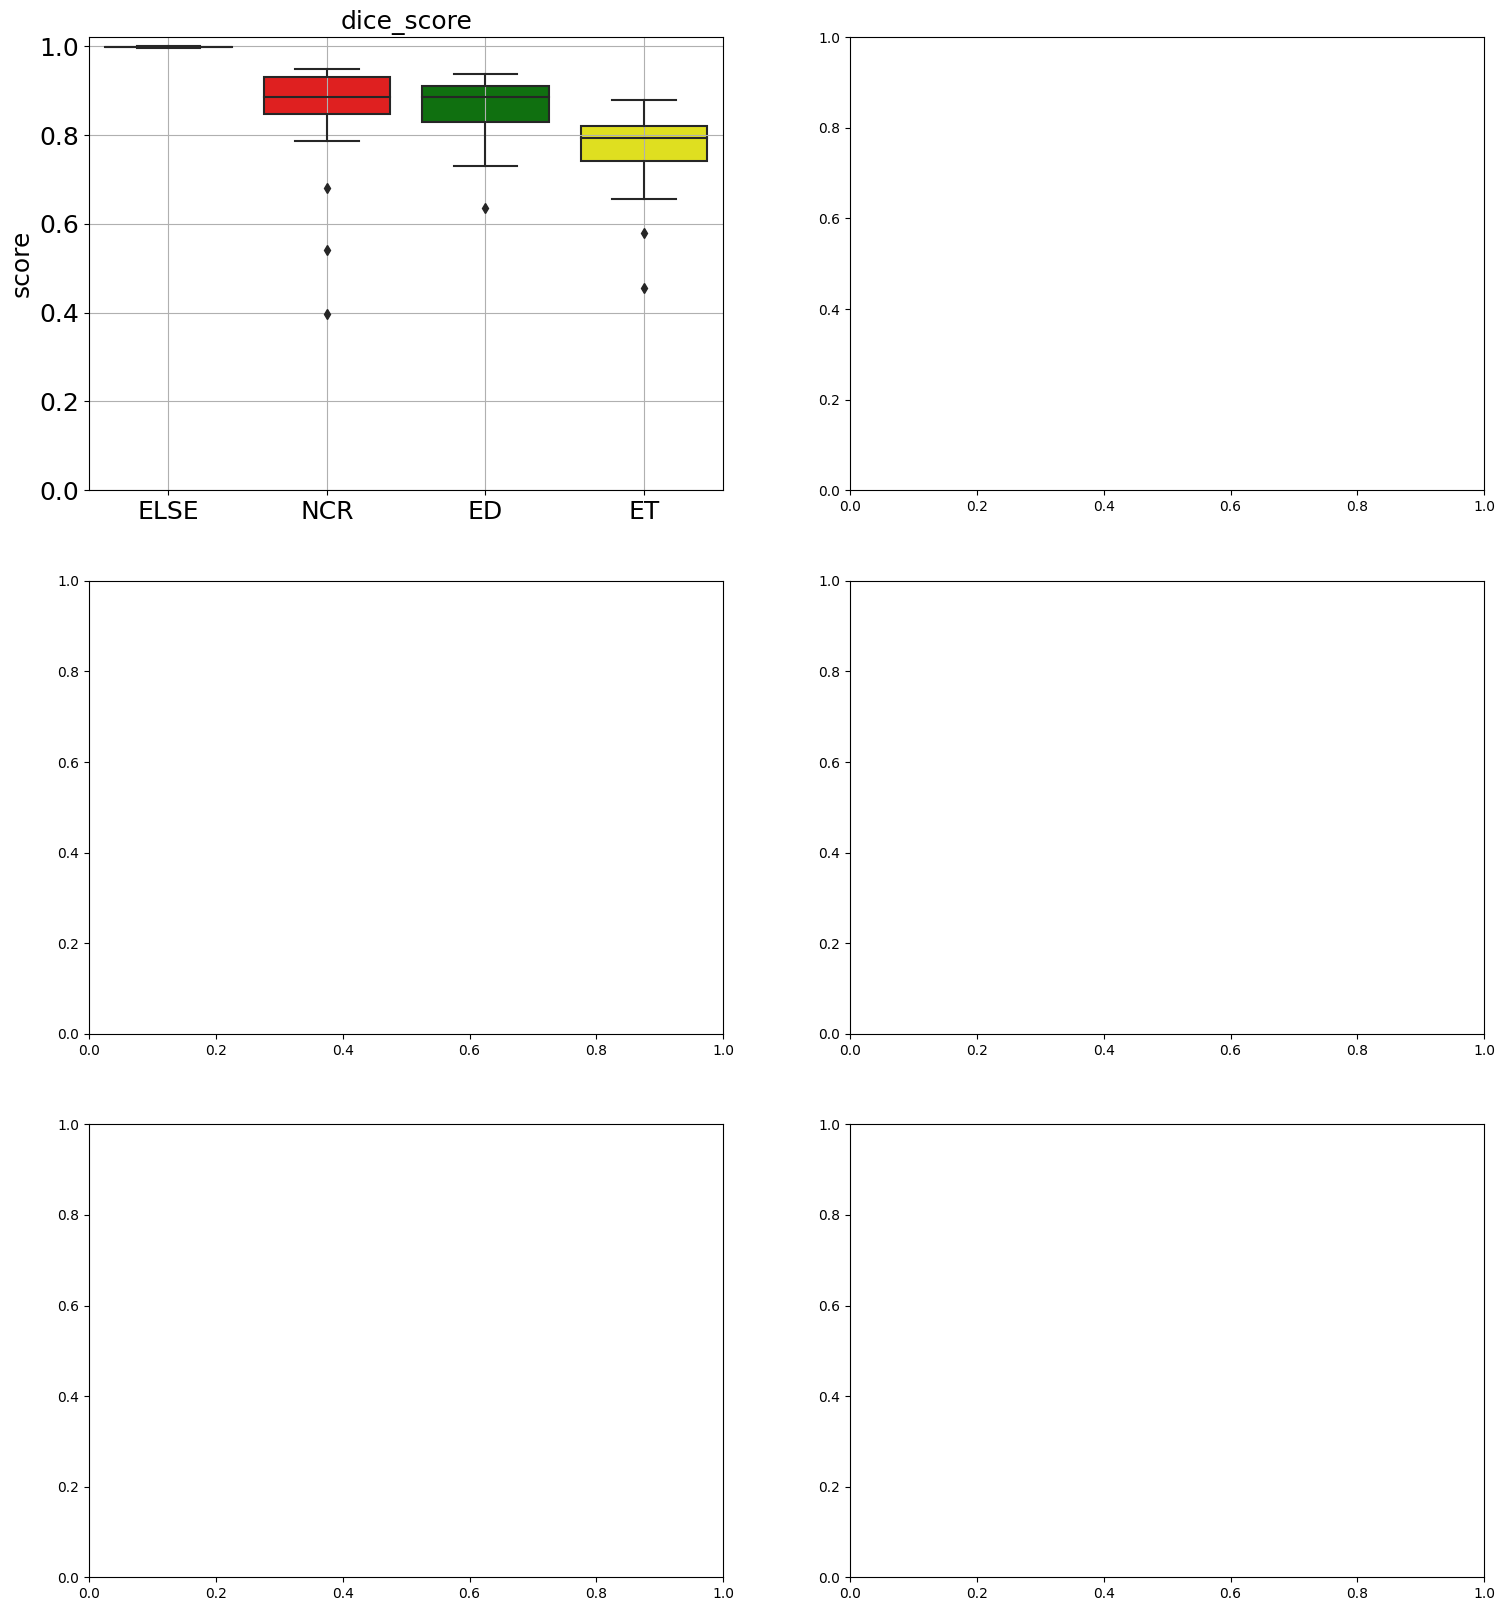

0.7684


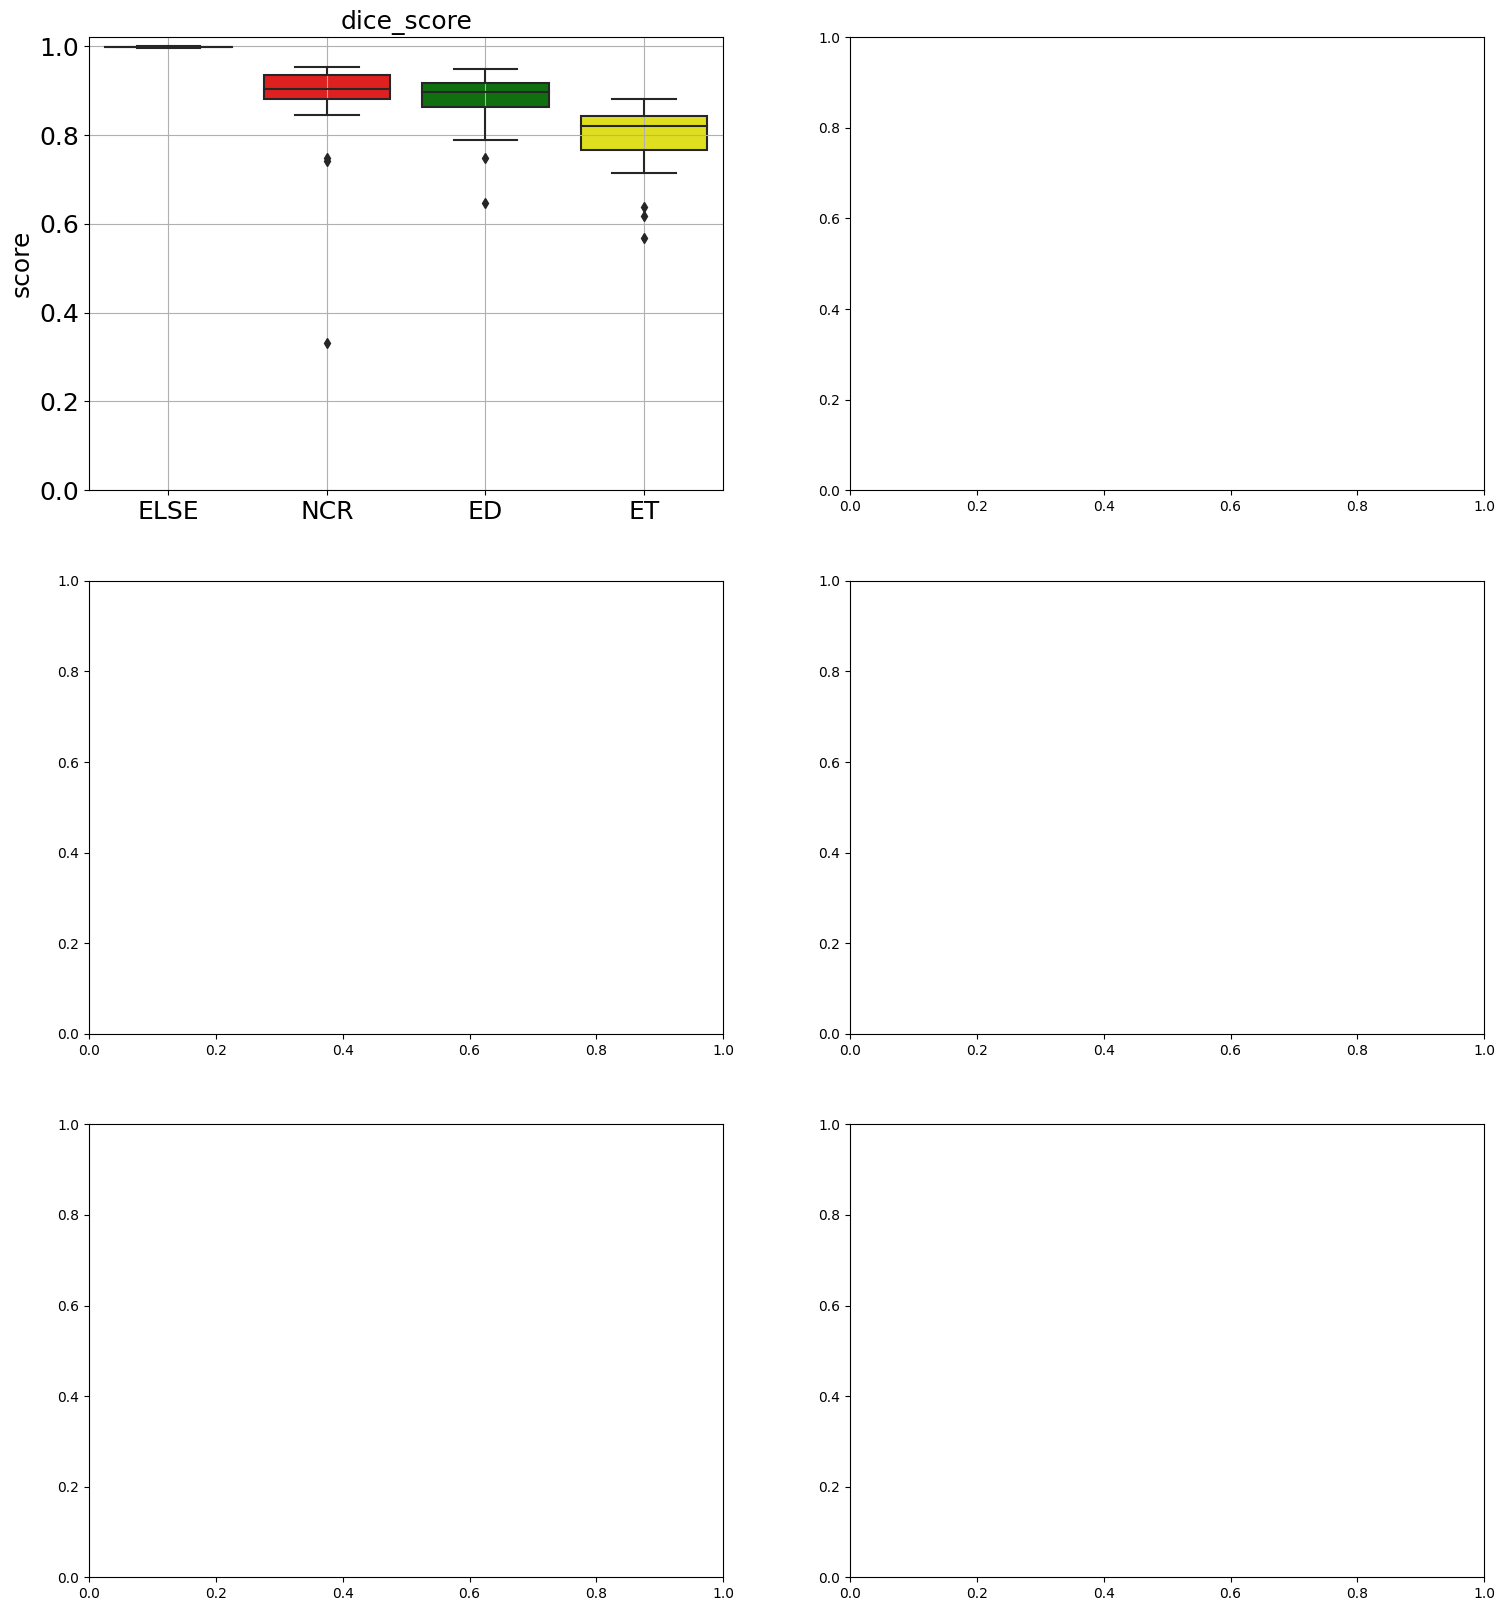

0.7923
[[0.9975475460600036 0.854483580858389  0.844261936255254
  0.758758286915775 ]
 [0.9980726298846364 0.8702980576082804 0.8483404233118943
  0.787630884352879 ]
 [0.9979170990991784 0.8565331971543451 0.860369070591109
  0.7684305214253543]
 [0.9981425549552049 0.879264732232196  0.8770323162452496
  0.7922542045234733]]


In [ ]:
# reuse boxplot function for the 6 metrics but with only the dice score.
# this is just for reporting purposes so the 5 box plots will be empty
for imodel in range(len(orientation_list)+1):
    metrics_dict = {}
    metrics_dict['dice_score'] = dice_score_results[imodel,:]
    mf_eval.draw_box_plots(metrics_dict, set_ylim=True)
    print(round(dice_score_results[imodel,:,3].mean(),4))

print(dice_score_results[:,:,:].mean(axis=1))

###### Plot comparision between the individual models and the ensemble

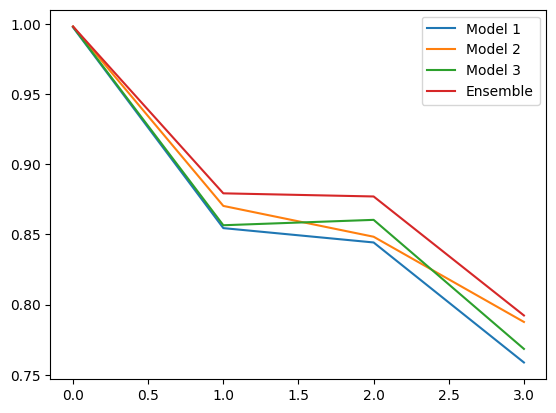

In [ ]:
x = np.arange(4)
plt.plot(x, dice_score_results[:,:,:].mean(axis=1)[0,:], label='Model 1')
plt.plot(x, dice_score_results[:,:,:].mean(axis=1)[1,:], label='Model 2')
plt.plot(x, dice_score_results[:,:,:].mean(axis=1)[2,:], label='Model 3')
plt.plot(x, dice_score_results[:,:,:].mean(axis=1)[3,:], label='Ensemble')
plt.legend()

Visualize comparision through bargraph

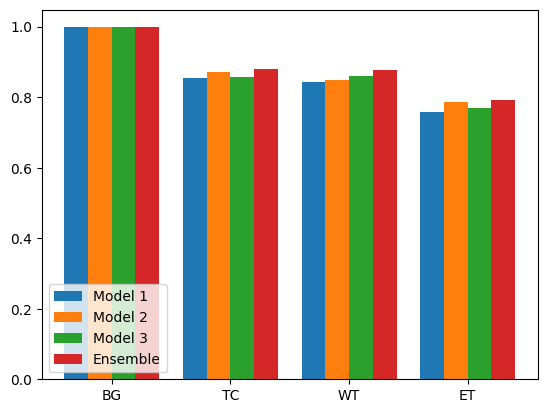

In [ ]:
x = np.arange(4)
width = 0.2

plt.bar(x - 3*width/2, dice_score_results[:,:,:].mean(axis=1)[0,:], width=width, label='Model 1')
plt.bar(x - width/2, dice_score_results[:,:,:].mean(axis=1)[1,:], width=width, label='Model 2')
plt.bar(x + width/2, dice_score_results[:,:,:].mean(axis=1)[2,:], width=width, label='Model 3')
plt.bar(x + 3*width/2, dice_score_results[:,:,:].mean(axis=1)[3,:], width=width, label='Ensemble')

plt.xticks(ticks=x, labels=['BG','TC','WT','ET'])
plt.legend(loc='lower left')
plt.show()